In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scipy
import os
from torch.optim import Adam
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.special import rel_entr
import lightning as L
from torch.utils.data import Dataset, DataLoader
from torch.nn import ReLU, Tanh, GELU
from NCP.nn.layers import MLP
from NCP.utils import frnp, FastTensorDataLoader
from NCP.nn.losses import CMELoss
from NCP.model import NCPOperator, NCPModule
from time import perf_counter
from NCP.cde_fork.density_simulation import EconDensity, LinearGaussian, ArmaJump, SkewNormal, EconDensity, GaussianMixture, JumpDiffusionModel
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [3]:
from scipy.integrate import cumulative_trapezoid
def integrate_pdf(pdf, values):
    return cumulative_trapezoid(pdf.squeeze(), x=values.squeeze(), initial=0)

# Class for preventing the wall of text
# https://github.com/Lightning-AI/pytorch-lightning/issues/15283
class LitProgressBar(L.pytorch.callbacks.TQDMProgressBar):
    def init_validation_tqdm(self):
        # bar = super().init_validation_tqdm()
        bar = tqdm(disable=True,)
        # bar.disable = True
        return bar

    def init_train_tqdm(self):
        bar = tqdm()
        bar.dynamic_ncols = False
        bar.ncols = 0
        bar.bar_format ='{desc} [{rate_fmt}{postfix}]'
        return bar

In [4]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint

class MyEarlyStopping(EarlyStopping):

    def on_train_end(self, trainer, pl_module):
        # instead, do it at the end of training loop
        self._run_early_stopping_check(trainer)

class CustomModelCheckpoint(ModelCheckpoint):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        X, Y = trainer.model.batch
        trainer.model.model._compute_data_statistics(X, Y)
        torch.save(trainer.model.model, trainer.checkpoint_callback.dirpath + '/best_model.pt')

## Linear gaussian

In [5]:
Ntrain = int(1e5)
Nval = int(1e3)
Ntest = int(1e3)

from math import sqrt
sigma_sq = .1
density = LinearGaussian(**{'ndim_x': 1, 'std': 0.1, 'random_seed': 42})
p_x = lambda x: (1/sqrt(2*np.pi)) * np.exp(-(x**2)/2)
p_y = lambda y: (1/(sqrt(2*np.pi)*sqrt(1+sigma_sq))) * np.exp(-(y**2)/(2*(1+sigma_sq)))

X, Y = density.simulate(n_samples=int(1e5) + Nval)
if X.ndim == 1:
    X = X.reshape((-1, 1))
    Y = Y.reshape((-1, 1))
X_train, X_val, Y_train, Y_val = X[:Ntrain], X[-Nval:], Y[:Ntrain], Y[-Nval:]
xscaler = StandardScaler()
yscaler = StandardScaler()
X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

X_test, Y_test = density.simulate(n_samples=Ntest)
if X_test.ndim == 1:
    X_test = X_test.reshape((-1, 1))
    Y_test = Y_test.reshape((-1, 1))
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)

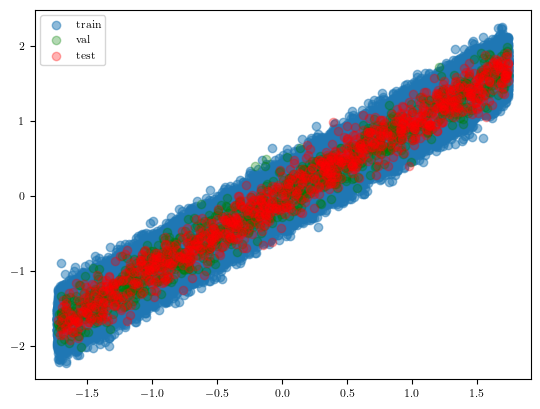

In [6]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [100]:
L.seed_everything(0)

lr = 1e-3
gamma = 1e-2
epochs = int(1e5)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': [64,64],
    'dropout': 0,
    'iterative_whitening': False,
    'activation': GELU
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    NCP_model,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

early_stop = EarlyStopping(monitor="val_loss", patience=200, mode="min")
ckpt_path = "checkpoints/NCP"
if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path)
checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min", dirpath=ckpt_path)

logger_path = "lightning_logs/NCP"
if not os.path.exists(logger_path):
    os.makedirs(logger_path)


trainer = L.Trainer(**{
    'accelerator': 'auto',
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': True,
    'num_sanity_val_steps': 0,
    'check_val_every_n_epoch': 10,
    'enable_model_summary': True,
}, callbacks=[LitProgressBar(), early_stop, checkpoint_callback])

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [101]:
start = perf_counter()
trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
print(f'Training time: {perf_counter()-start}')

/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /media/gturri/deploy/NCP/NCP/examples/checkpoints/NCP exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 21.5 K
--------------------------------------
21.5 K    Trainable params
0         Non-trainable params
21.5 K    Total params
0.086     Total estimated model params size (MB)


0it [00:00, ?it/s]

Training time: 149.11240451797494


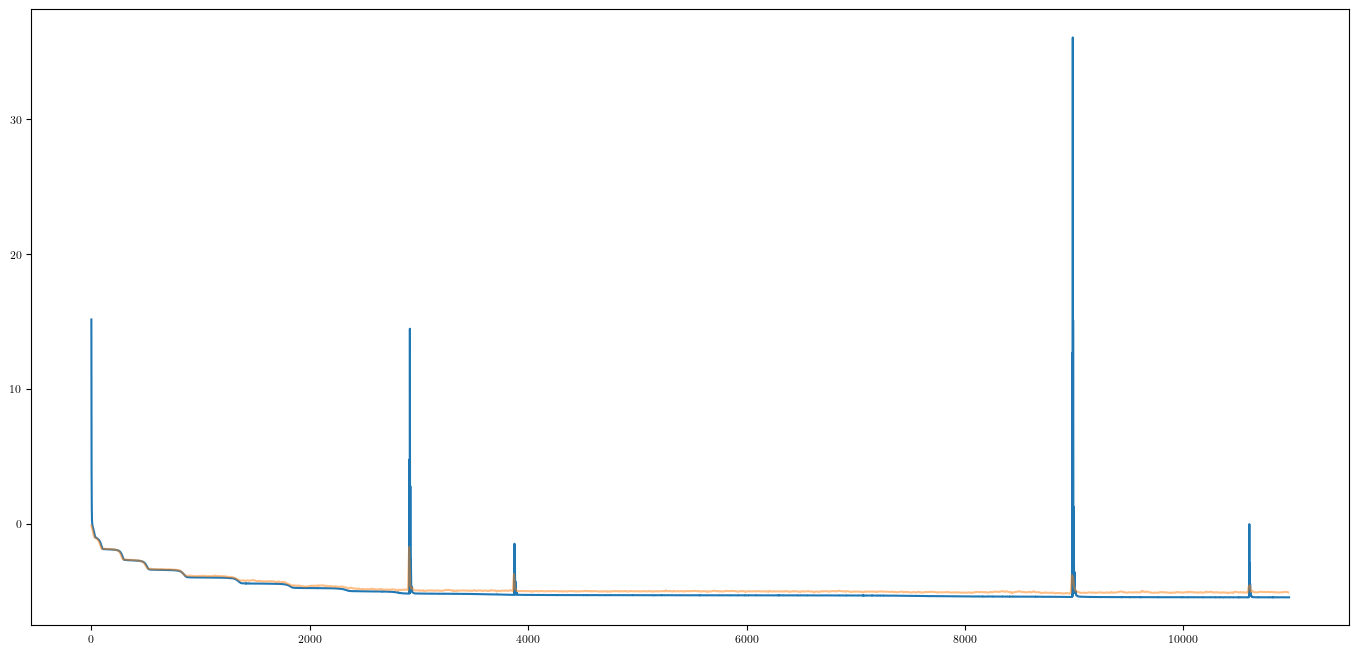

In [102]:
plt.figure(figsize=(17, 8))
plt.plot(np.arange(0, NCP_module.current_epoch, 1), np.array(NCP_module.train_loss))
plt.plot(np.arange(0, NCP_module.current_epoch, 10), np.array(NCP_module.val_loss), alpha=.5)
# plt.yscale('log')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (10970,) and (0,)

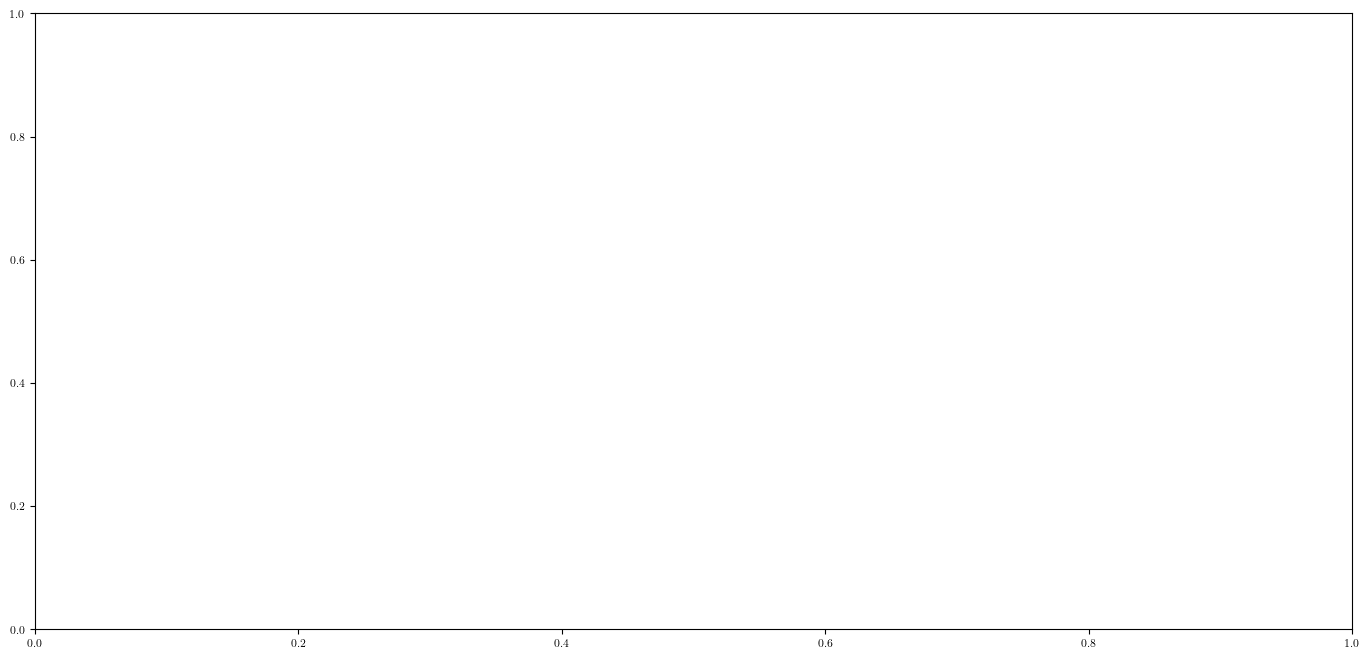

In [103]:
plt.figure(figsize=(17, 8))
plt.plot(np.arange(0, NCP_module.current_epoch, 1), np.array(NCP_module.S_gradients))
plt.show()

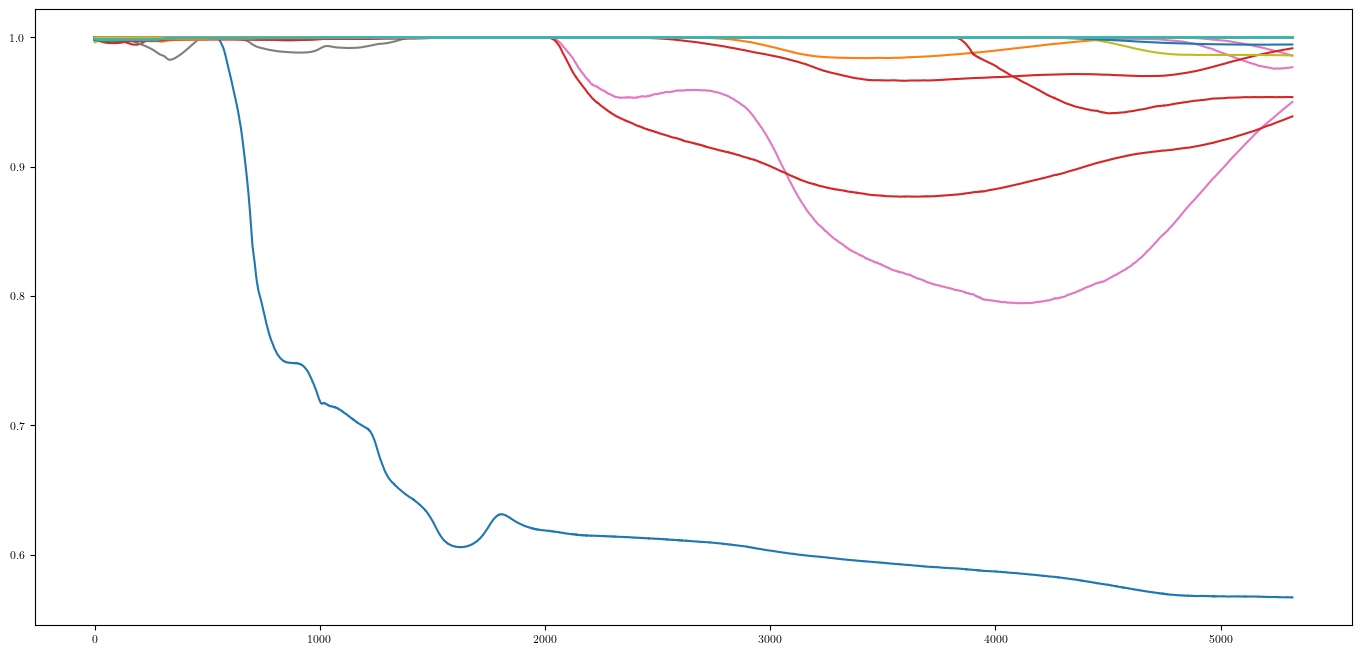

In [11]:
plt.figure(figsize=(17, 8))
plt.plot(np.arange(0, NCP_module.current_epoch, 1), np.exp(-np.array(NCP_module.S_weights)**2))
plt.show()

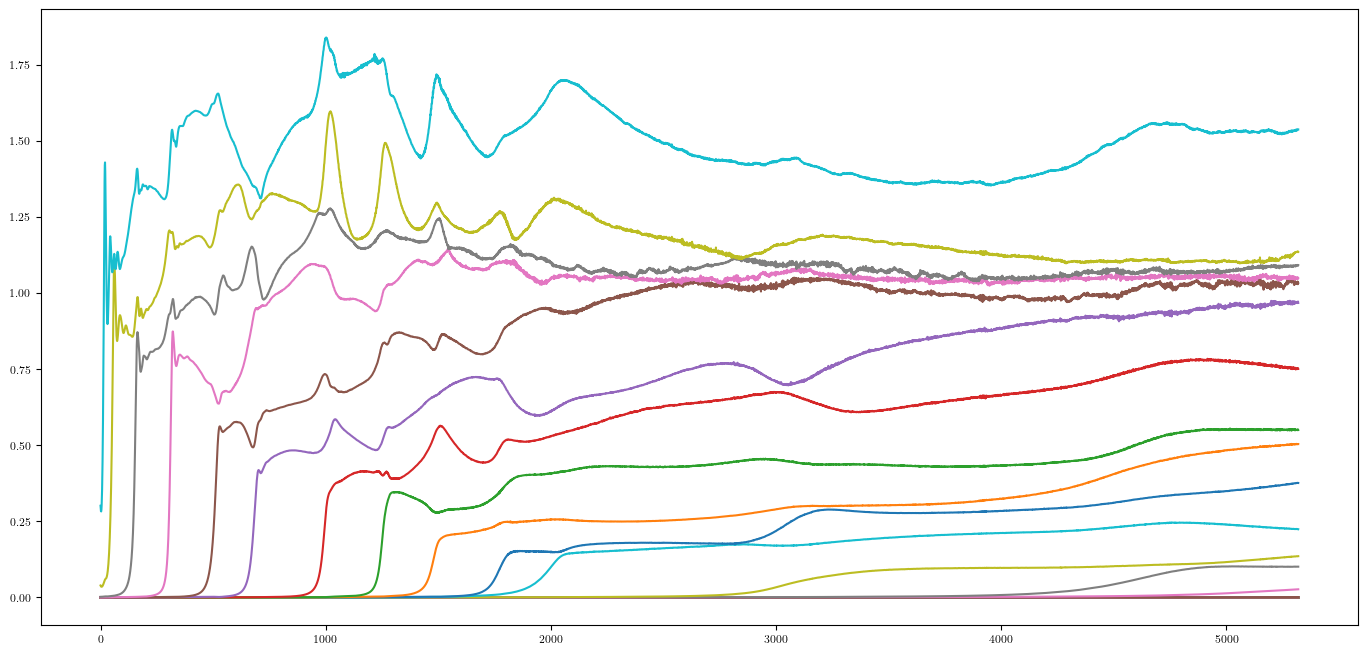

In [12]:
plt.figure(figsize=(17, 8))
plt.plot(np.sort(np.array(NCP_module.U_eigs).real,axis=1))
plt.show()

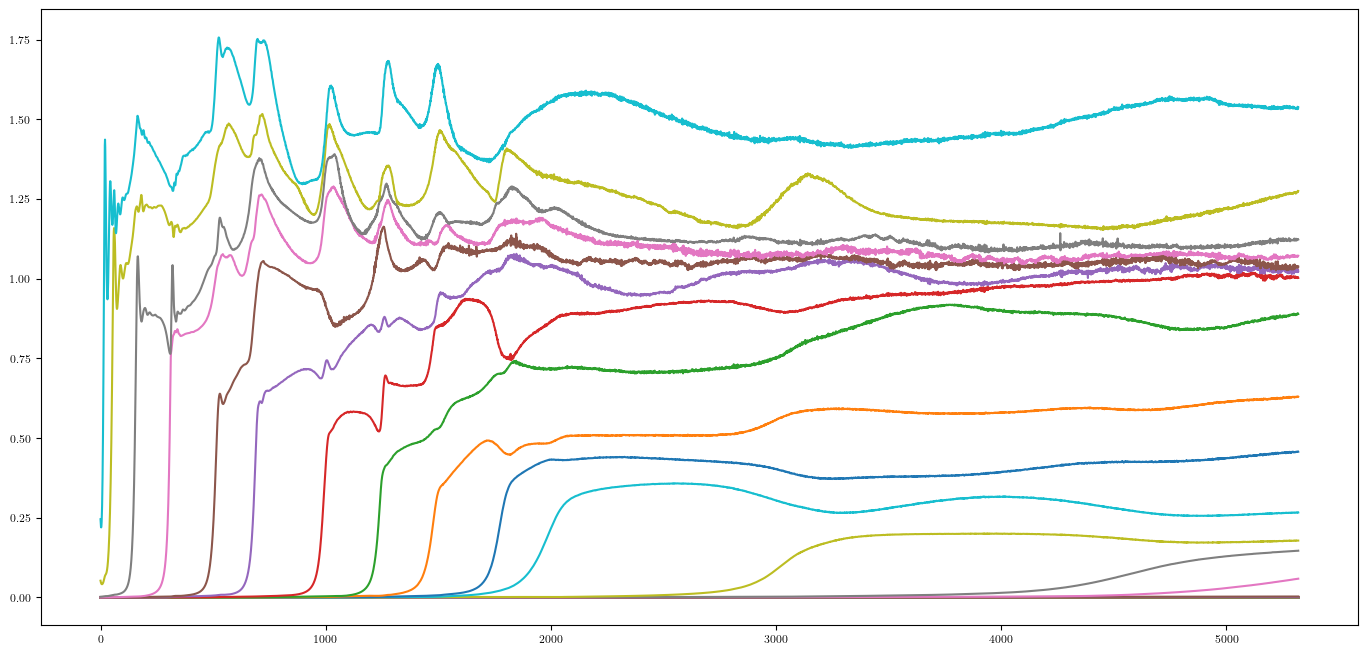

In [13]:
plt.figure(figsize=(17, 8))
plt.plot(np.sort(np.array(NCP_module.V_eigs).real,axis=1))
plt.show()

In [104]:
best_model = torch.load(ckpt_path + '/best_model.pt').to('cpu')
print(checkpoint_callback.best_model_path)

/media/gturri/deploy/NCP/NCP/examples/checkpoints/NCP/epoch=8969-step=8970-v3.ckpt


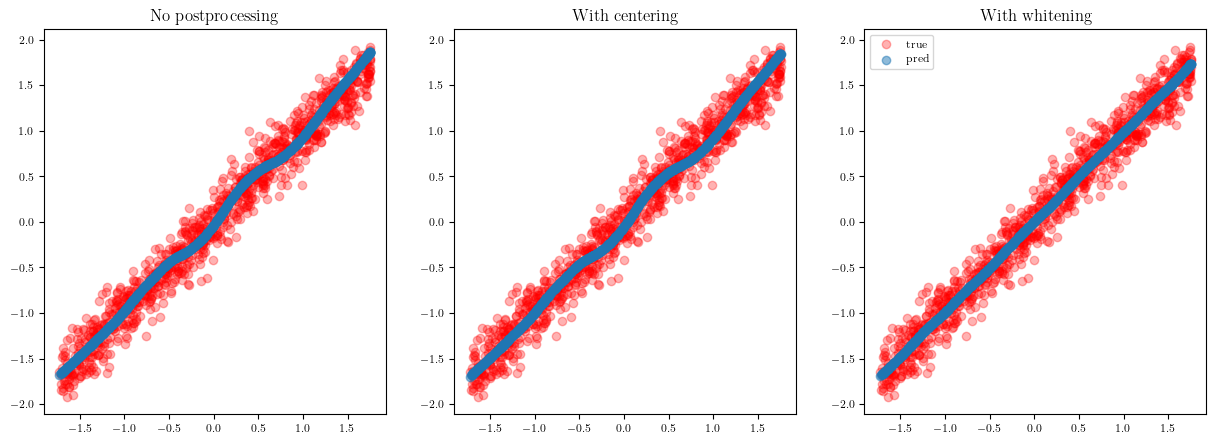

In [105]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = best_model.conditional_expectation(frnp(X_test), frnp(Y_train)).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = best_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = best_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

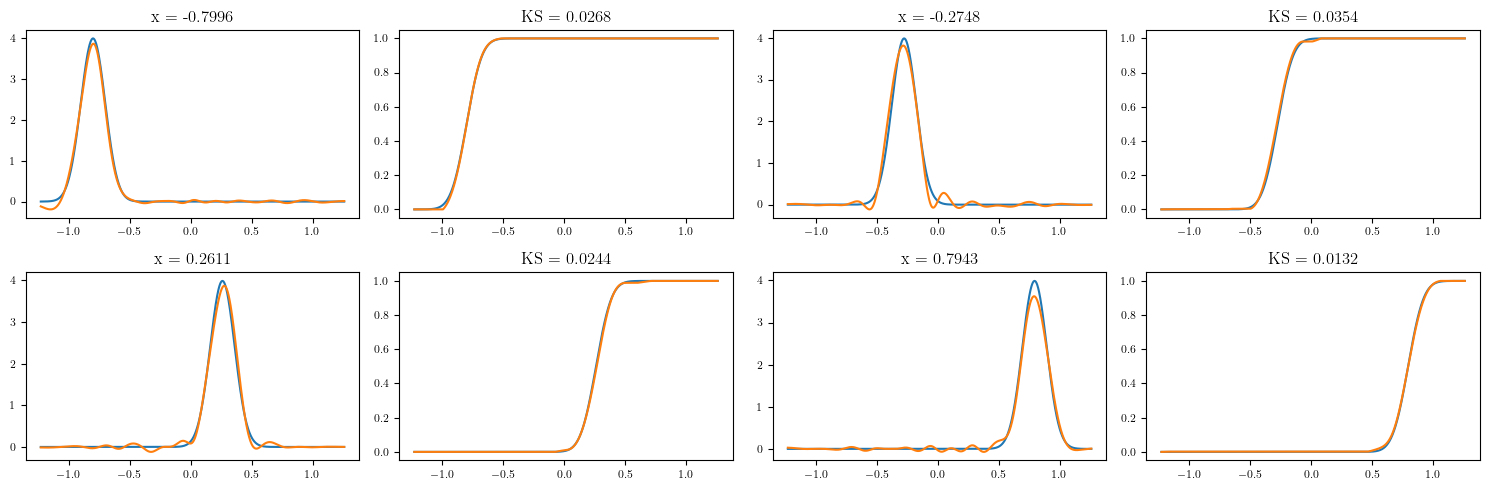

In [107]:
from NCP.cdf import compute_marginal, integrate_pdf
from NCP.metrics import *

x_grid = np.percentile(X_train, np.linspace(10, 90, num=4))
ys, step = np.linspace(Y_train.min(), Y_train.max(), num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))
p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
axes = ax.flatten()
postprocess = 'whitening'
for i, xi in enumerate(x_grid):
    xi = xi.reshape(1, -1)
    fys, pred_pdf = best_model.pdf(frnp([[xi]]), frnp(ys), postprocess=postprocess, p_y=p_y)
    fys = fys.reshape(-1, 1)
    true_pdf = density.pdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                           yscaler.inverse_transform(ys)).squeeze()
    axes[i*2].plot(yscaler.inverse_transform(fys), true_pdf)
    axes[i*2].plot(yscaler.inverse_transform(fys), pred_pdf.squeeze()/yscaler.scale_)

    pred_cdf = integrate_pdf(pred_pdf, ys)
    true_cdf = density.cdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                           yscaler.inverse_transform(ys)).squeeze()
    axes[i*2+1].plot(yscaler.inverse_transform(fys), true_cdf)
    axes[i*2+1].plot(yscaler.inverse_transform(fys), smooth_cdf(fys, pred_cdf))

    axes[i*2].set_title(r'x = {0:.4f}'.format(xscaler.inverse_transform(xi).squeeze()))
    axes[i*2+1].set_title(r'KS = {0:.4f}'.format(kolmogorov_smirnov(true_cdf, pred_cdf, fys)))
    
plt.tight_layout()
plt.show()

In [108]:
x_grid = np.percentile(X_train, np.linspace(5, 95, num=19))
ys, step = np.linspace(Y_train.min(), Y_train.max(), num=1000, retstep=True)
ys = ys.reshape(-1, 1)

postprocess = 'centering'
scores = []
for xi in x_grid:
    fys, pred_pdf = best_model.pdf(frnp([[xi]]), frnp(ys), postprocess=postprocess, p_y=p_y)
    # pred_cdf = pdf2cdf(pred_pdf, step)
    pred_cdf = integrate_pdf(pred_pdf, ys)
    true_cdf = density.cdf(np.tile(xscaler.inverse_transform([[xi]]), (len(ys),1)),
                                           yscaler.inverse_transform(ys)).squeeze()

    result = compute_metrics(true_cdf, pred_cdf, metrics='all', smooth=True, values=fys)
    result['x'] = xi

    scores.append(result)
scores = pd.DataFrame(scores)

In [109]:
scores.kolmogorov_smirnov.mean()

0.046782922

In [25]:
np.sort(np.exp(-best_model.state_dict()['S.weights']**2))

array([0.5964932 , 0.8402388 , 0.88173324, 0.97071767, 0.9842787 ,
       0.99998564, 0.99999756, 0.9999997 , 0.9999999 , 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [26]:
best_model.state_dict()['_sing_val']

tensor([0.9877, 0.9519, 0.8984, 0.8290, 0.7450, 0.6620, 0.5675, 0.4811, 0.4095,
        0.3386, 0.2767, 0.2131, 0.1534, 0.1237, 0.0868, 0.0778, 0.0432, 0.0211])

## ECON 

In [27]:
sigma_sq = 1
Ntrain = int(1e4)
Nval = int(1e3)
Ntest = int(1e3)

density = EconDensity(std= sigma_sq, heteroscedastic=True, random_seed=42)
X, Y = density.simulate(n_samples=int(1e5) + Nval)
if X.ndim == 1:
    X = X.reshape((-1, 1))
    Y = Y.reshape((-1, 1))
X_train, X_val, Y_train, Y_val = X[:Ntrain], X[-Nval:], Y[:Ntrain], Y[-Nval:]
xscaler = StandardScaler()
yscaler = StandardScaler()
X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

X_test, Y_test = density.simulate(n_samples=Ntest)
if X_test.ndim == 1:
    X_test = X_test.reshape((-1, 1))
    Y_test = Y_test.reshape((-1, 1))
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)

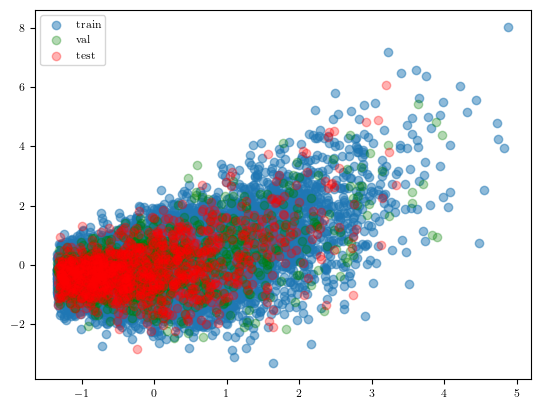

In [28]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [29]:
L.seed_everything(0)

lr = 1e-3
gamma = 1e-3
epochs = int(1e5)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': [64,64],
    'dropout': 0,
    'iterative_whitening': False,
    'activation': GELU
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    NCP_model,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

early_stop = EarlyStopping(monitor="val_loss", patience=200, mode="min")
ckpt_path = "checkpoints/NCP"
if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path)
checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min", dirpath=ckpt_path)

logger_path = "lightning_logs/NCP"
if not os.path.exists(logger_path):
    os.makedirs(logger_path)


trainer = L.Trainer(**{
    'accelerator': 'auto',
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': True,
    'num_sanity_val_steps': 0,
    'check_val_every_n_epoch': 10,
    'enable_model_summary': True,
}, callbacks=[LitProgressBar(), early_stop, checkpoint_callback])

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [30]:
start = perf_counter()
trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
print(f'Training time: {perf_counter()-start}')

/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /media/gturri/deploy/NCP/NCP/examples/checkpoints/NCP exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 21.5 K
--------------------------------------
21.5 K    Trainable params
0         Non-trainable params
21.5 K    Total params
0.086     Total estimated model params size (MB)


0it [00:00, ?it/s]

Training time: 433.4766759260092


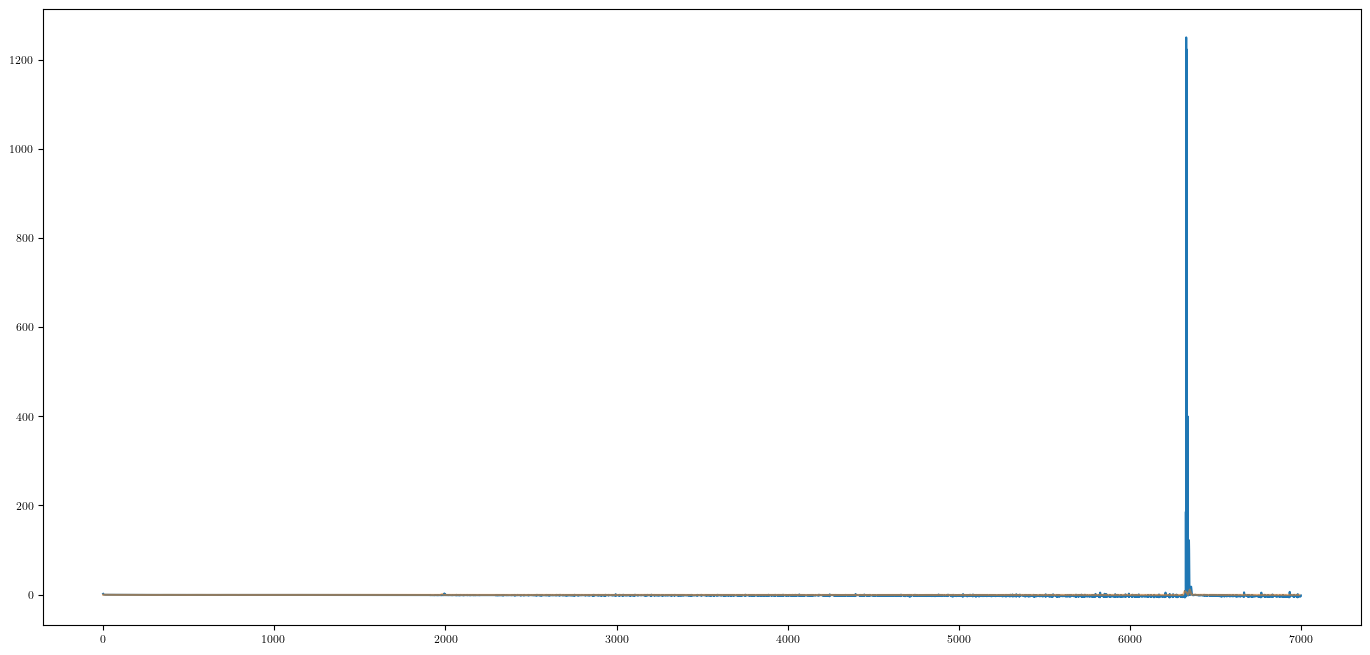

In [31]:
plt.figure(figsize=(17, 8))
plt.plot(np.arange(0, NCP_module.current_epoch, 1), np.array(NCP_module.train_loss))
plt.plot(np.arange(0, NCP_module.current_epoch, 10), np.array(NCP_module.val_loss), alpha=.5)
# plt.yscale('log')
plt.show()

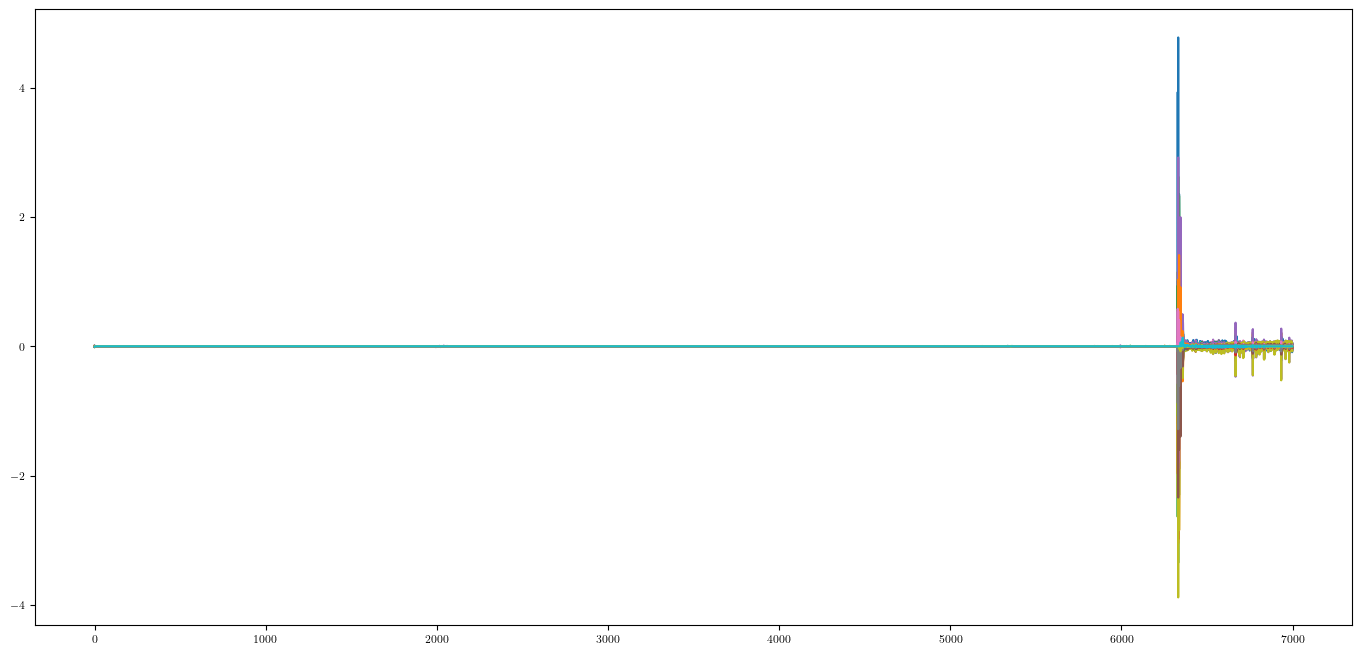

In [32]:
plt.figure(figsize=(17, 8))
plt.plot(np.arange(0, NCP_module.current_epoch, 1), np.array(NCP_module.S_gradients))
plt.show()

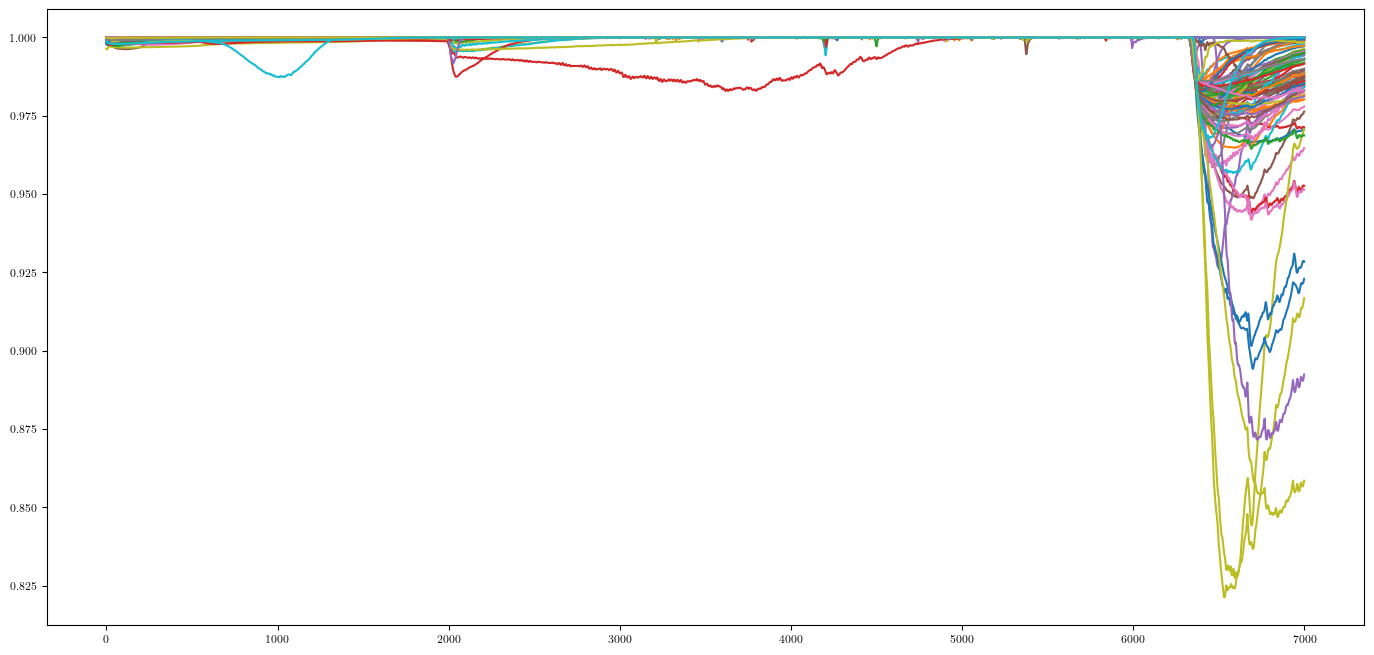

In [33]:
plt.figure(figsize=(17, 8))
plt.plot(np.arange(0, NCP_module.current_epoch, 1), np.exp(-np.array(NCP_module.S_weights)**2))
plt.show()

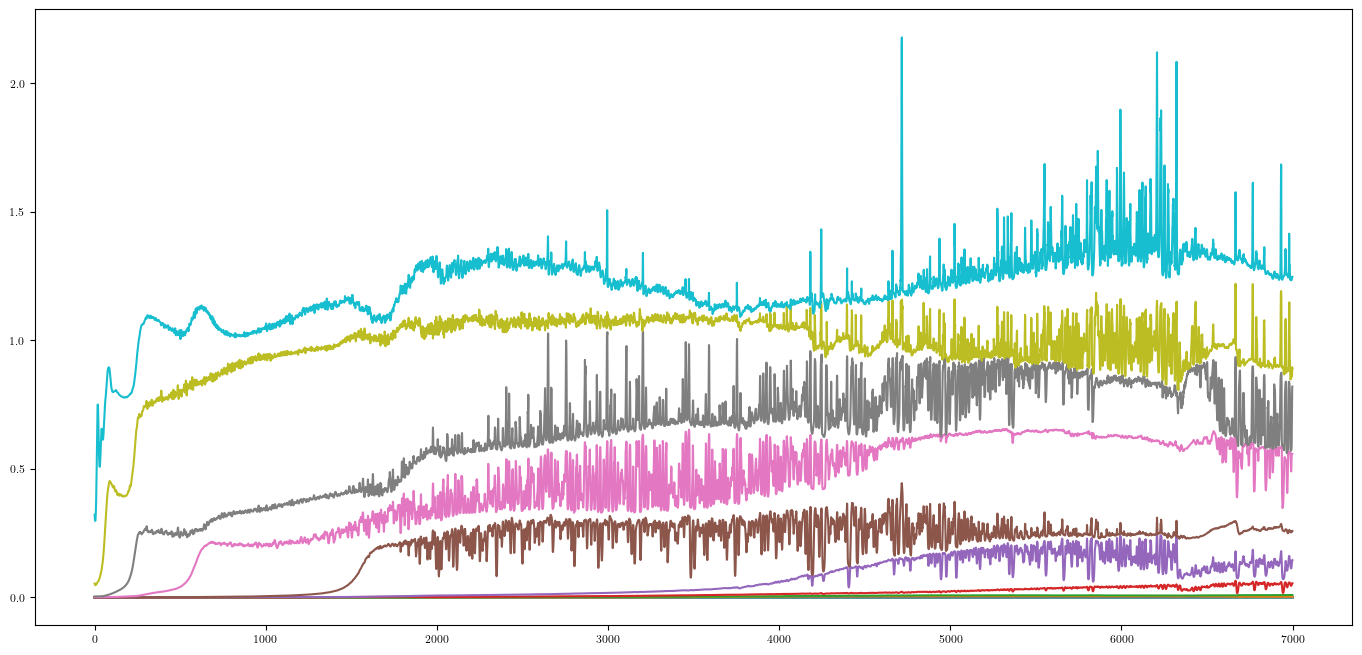

In [34]:
plt.figure(figsize=(17, 8))
plt.plot(np.sort(np.array(NCP_module.U_eigs).real,axis=1))
plt.show()

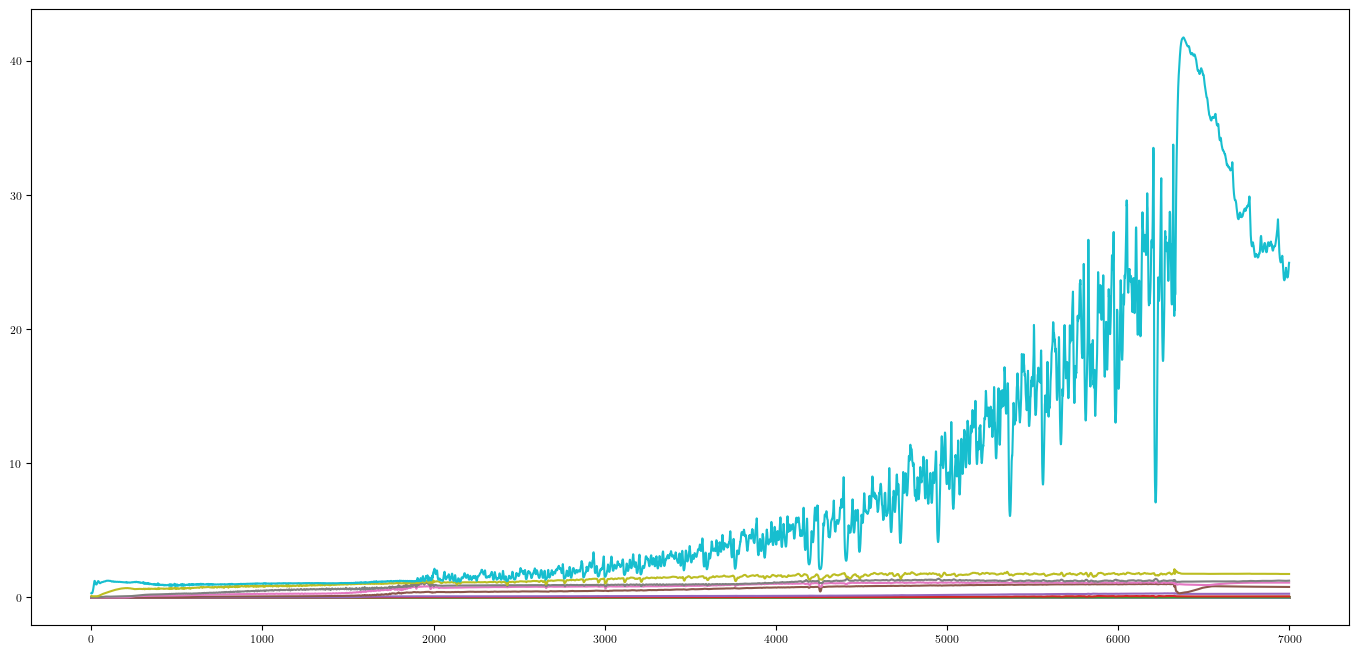

In [35]:
plt.figure(figsize=(17, 8))
plt.plot(np.sort(np.array(NCP_module.V_eigs).real,axis=1))
plt.show()

In [36]:
best_model = torch.load(ckpt_path + '/best_model.pt').to('cpu')
print(checkpoint_callback.best_model_path)

/media/gturri/deploy/NCP/NCP/examples/checkpoints/NCP/epoch=4999-step=5000-v7.ckpt


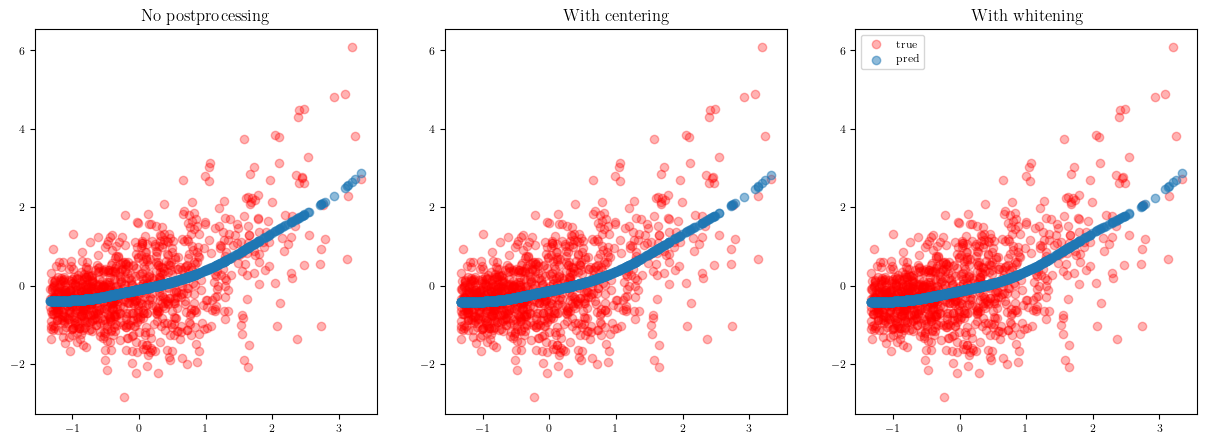

In [37]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = best_model.conditional_expectation(frnp(X_test), frnp(Y_train)).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = best_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = best_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

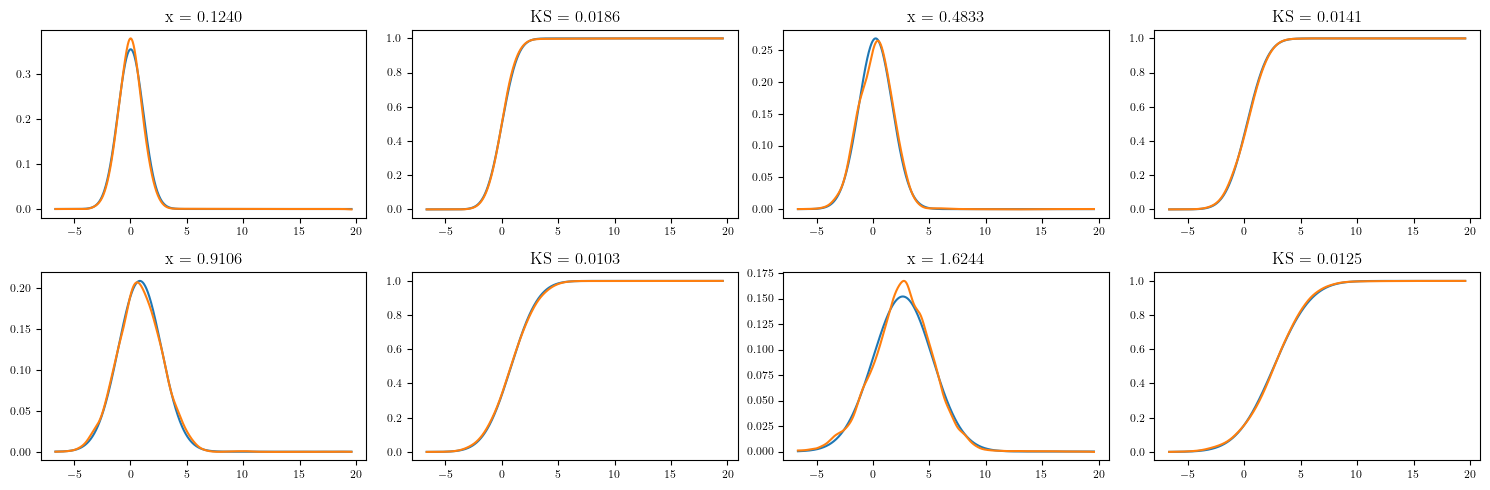

In [38]:
from NCP.cdf import compute_marginal, integrate_pdf
from NCP.metrics import *

x_grid = np.percentile(X_train, np.linspace(10, 90, num=4))
ys, step = np.linspace(Y_train.min(), Y_train.max(), num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))
p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
axes = ax.flatten()
postprocess = 'centering'
for i, xi in enumerate(x_grid):
    xi = xi.reshape(1, -1)
    fys, pred_pdf = best_model.pdf(frnp([[xi]]), frnp(ys), postprocess=postprocess, p_y=p_y)
    fys = fys.reshape(-1, 1)
    true_pdf = density.pdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                           yscaler.inverse_transform(ys)).squeeze()
    axes[i*2].plot(yscaler.inverse_transform(fys), true_pdf)
    axes[i*2].plot(yscaler.inverse_transform(fys), pred_pdf.squeeze()/yscaler.scale_)

    pred_cdf = integrate_pdf(pred_pdf, ys)
    true_cdf = density.cdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                           yscaler.inverse_transform(ys)).squeeze()
    axes[i*2+1].plot(yscaler.inverse_transform(fys), true_cdf)
    axes[i*2+1].plot(yscaler.inverse_transform(fys), smooth_cdf(fys, pred_cdf))

    axes[i*2].set_title(r'x = {0:.4f}'.format(xscaler.inverse_transform(xi).squeeze()))
    axes[i*2+1].set_title(r'KS = {0:.4f}'.format(kolmogorov_smirnov(true_cdf, pred_cdf, fys)))

plt.tight_layout()
plt.show()

In [39]:
x_grid = np.percentile(X_train, np.linspace(5, 95, num=19))
ys, step = np.linspace(Y_train.min(), Y_train.max(), num=1000, retstep=True)
ys = ys.reshape(-1, 1)

postprocess = 'centering'
scores = []
for xi in x_grid:
    fys, pred_pdf = best_model.pdf(frnp([[xi]]), frnp(ys), postprocess=postprocess, p_y=p_y)
    # pred_cdf = pdf2cdf(pred_pdf, step)
    pred_cdf = integrate_pdf(pred_pdf, ys)
    true_cdf = density.cdf(np.tile(xscaler.inverse_transform([[xi]]), (len(ys),1)),
                                           yscaler.inverse_transform(ys)).squeeze()

    result = compute_metrics(true_cdf, pred_cdf, metrics='all', smooth=True, values=fys)
    result['x'] = xi

    scores.append(result)
scores = pd.DataFrame(scores)

In [40]:
scores.kolmogorov_smirnov.mean()

0.013300047

In [41]:
scores.kolmogorov_smirnov.mean()

0.013300047

In [42]:
np.sort(np.exp(-best_model.state_dict()['S.weights']**2))

array([0.99973273, 0.9998997 , 0.9999231 , 0.9999635 , 0.999986  ,
       0.99999344, 0.99999875, 0.99999946, 0.9999997 , 0.9999999 ,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [43]:
best_model.state_dict()['_sing_val']

tensor([0.8575, 0.6683, 0.4609, 0.3035, 0.2059, 0.1492, 0.1088, 0.0688, 0.0499,
        0.0231, 0.0145, 0.0082])

In [44]:
torch.exp(-(torch.ones((10,))*1)**2)

tensor([0.3679, 0.3679, 0.3679, 0.3679, 0.3679, 0.3679, 0.3679, 0.3679, 0.3679,
        0.3679])

## ARMA Jump 

In [13]:
Ntrain = int(1e5)
Nval = int(1e3)
Ntest = int(1e3)

density = ArmaJump(random_seed=42)
X, Y = density.simulate(n_samples=int(1e5) + Nval)
# shuffle the dataset
idx = np.random.permutation(len(X))
X, Y = X[idx], Y[idx]
if X.ndim == 1:
    X = X.reshape((-1, 1))
    Y = Y.reshape((-1, 1))
X_train, X_val, Y_train, Y_val = X[:Ntrain], X[-Nval:], Y[:Ntrain], Y[-Nval:]
xscaler = StandardScaler()
yscaler = StandardScaler()
X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

X_test, Y_test = density.simulate(n_samples=Ntest)
if X_test.ndim == 1:
    X_test = X_test.reshape((-1, 1))
    Y_test = Y_test.reshape((-1, 1))
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)

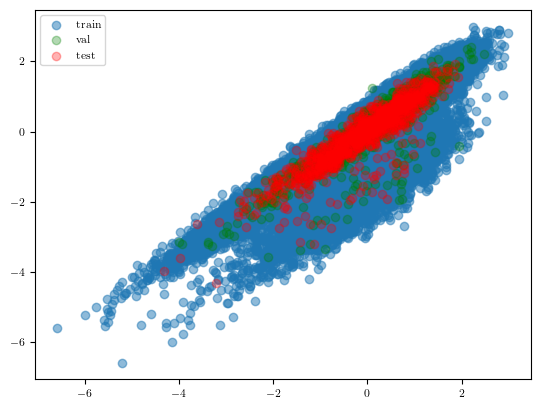

In [14]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [15]:
L.seed_everything(0)

lr = 1e-3
gamma = 1e-3
epochs = int(1e5)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': [64,64],
    'dropout': 0,
    'iterative_whitening': False,
    'activation': GELU
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    NCP_model,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

early_stop = EarlyStopping(monitor="val_loss", patience=100, mode="min")
ckpt_path = "checkpoints/NCP"
if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path)
checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min", dirpath=ckpt_path)

logger_path = "lightning_logs/NCP"
if not os.path.exists(logger_path):
    os.makedirs(logger_path)


trainer = L.Trainer(**{
    'accelerator': 'auto',
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': True,
    'num_sanity_val_steps': 0,
    'check_val_every_n_epoch': 5,
    'enable_model_summary': True,
}, callbacks=[LitProgressBar(), early_stop, checkpoint_callback])

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
start = perf_counter()
trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
print(f'Training time: {perf_counter()-start}')

/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /media/gturri/deploy/NCP/NCP/examples/checkpoints/NCP exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 21.5 K
--------------------------------------
21.5 K    Trainable params
0         Non-trainable params
21.5 K    Total params
0.086     Total estimated model params size (MB)


0it [00:00, ?it/s]

Training time: 167.12460822198773


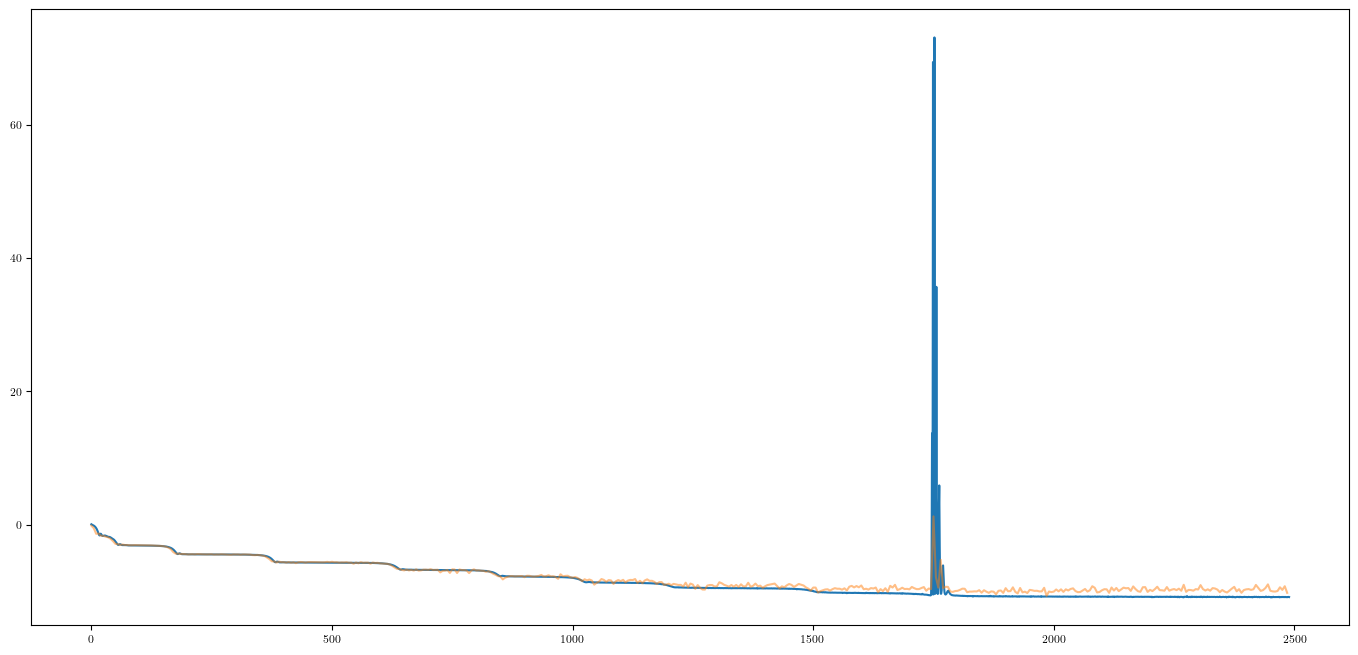

In [17]:
plt.figure(figsize=(17, 8))
plt.plot(np.arange(0, NCP_module.current_epoch, 1), np.array(NCP_module.train_loss))
plt.plot(np.arange(0, NCP_module.current_epoch, 5), np.array(NCP_module.val_loss), alpha=.5)
# plt.yscale('log')
plt.show()

In [18]:
print('N epochs: {0}'.format(NCP_module.current_epoch - early_stop.patience*trainer.check_val_every_n_epoch-1))
print('Training loss: {0}'.format(NCP_module.train_loss[-early_stop.patience*trainer.check_val_every_n_epoch-1]))
print('Validation loss: {0}'.format(NCP_module.val_loss[-early_stop.patience-1]))

N epochs: 1989
Training loss: -10.797239303588867
Validation loss: -10.679248809814453


In [19]:
best_model = torch.load(ckpt_path + '/best_model.pt').to('cpu')
print(checkpoint_callback.best_model_path)

/media/gturri/deploy/NCP/NCP/examples/checkpoints/NCP/epoch=1989-step=1990-v2.ckpt


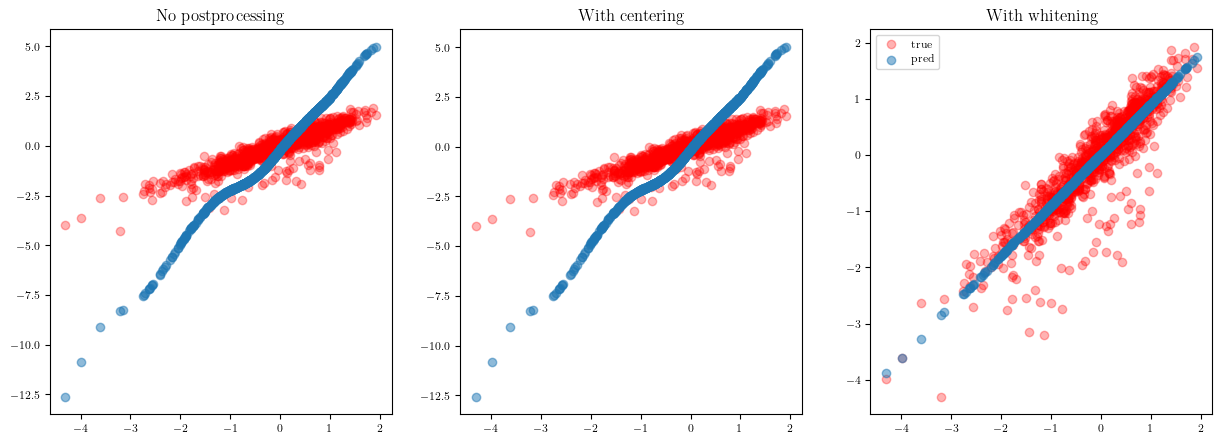

In [20]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = best_model.conditional_expectation(frnp(X_test), frnp(Y_train)).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = best_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = best_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

/media/gturri/deploy/NCP/NCP/utils.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.Tensor(x).to(device)


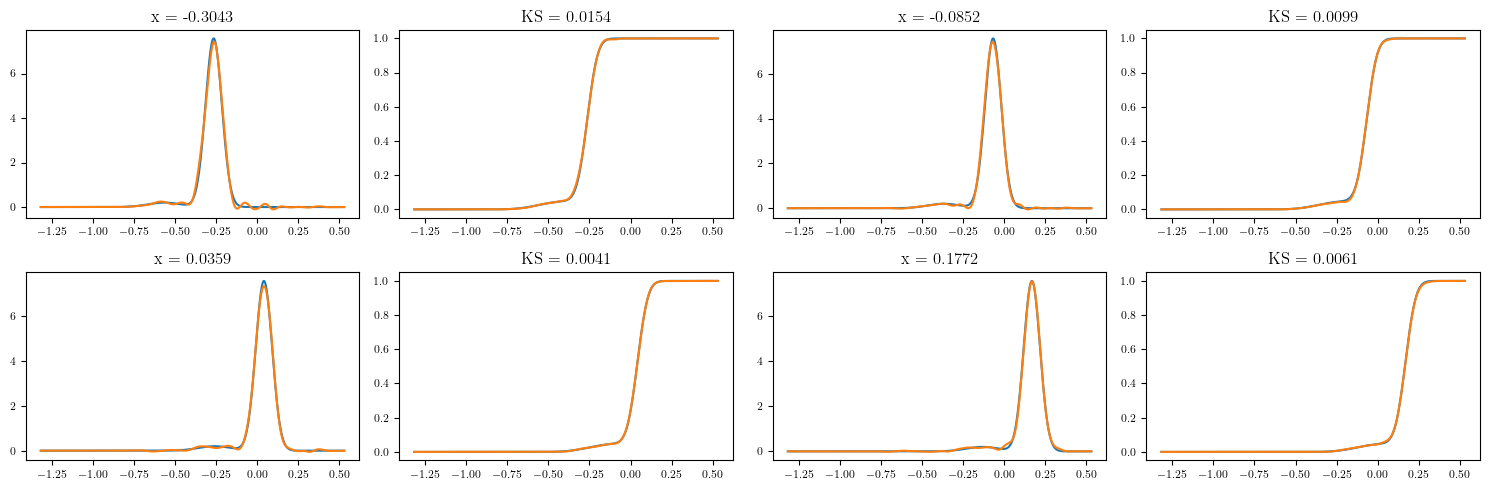

In [21]:
from NCP.cdf import compute_marginal, integrate_pdf
from NCP.metrics import *

x_grid = np.percentile(X_train, np.linspace(10, 90, num=4))
ys, step = np.linspace(Y_train.min(), Y_train.max(), num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))
p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
axes = ax.flatten()
postprocess = 'whitening'
for i, xi in enumerate(x_grid):
    xi = xi.reshape(1, -1)
    fys, pred_pdf = best_model.pdf(frnp([[xi]]), frnp(ys), postprocess=postprocess, p_y=p_y)
    fys = fys.reshape(-1, 1)
    true_pdf = density.pdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                           yscaler.inverse_transform(ys)).squeeze()
    axes[i*2].plot(yscaler.inverse_transform(fys), true_pdf)
    axes[i*2].plot(yscaler.inverse_transform(fys), pred_pdf.squeeze()/yscaler.scale_)

    pred_cdf = integrate_pdf(pred_pdf, ys)
    true_cdf = density.cdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                           yscaler.inverse_transform(ys)).squeeze()
    axes[i*2+1].plot(yscaler.inverse_transform(fys), true_cdf)
    axes[i*2+1].plot(yscaler.inverse_transform(fys), smooth_cdf(fys, pred_cdf))

    axes[i*2].set_title(r'x = {0:.4f}'.format(xscaler.inverse_transform(xi).squeeze()))
    axes[i*2+1].set_title(r'KS = {0:.4f}'.format(kolmogorov_smirnov(true_cdf, pred_cdf, fys)))

plt.tight_layout()
plt.show()

In [77]:
x_grid = np.percentile(X_train, np.linspace(5, 95, num=19))
ys, step = np.linspace(Y_train.min(), Y_train.max(), num=1000, retstep=True)
ys = ys.reshape(-1, 1)

postprocess = 'whitening'
scores = []
for xi in x_grid:
    fys, pred_pdf = best_model.pdf(frnp([[xi]]), frnp(ys), postprocess=postprocess, p_y=p_y)
    # pred_cdf = pdf2cdf(pred_pdf, step)
    pred_cdf = integrate_pdf(pred_pdf, ys)
    true_cdf = density.cdf(np.tile(xscaler.inverse_transform([[xi]]), (len(ys),1)),
                                           yscaler.inverse_transform(ys)).squeeze()

    result = compute_metrics(true_cdf, pred_cdf, metrics='all', smooth=True, values=fys)
    result['x'] = xi

    scores.append(result)
scores = pd.DataFrame(scores)

In [78]:
scores.kolmogorov_smirnov.mean()

0.014196238

In [57]:
np.sort(np.exp(-best_model.state_dict()['S.weights']**2))

array([0.9699535 , 0.97580045, 0.97721124, 0.98067516, 0.98117155,
       0.98628527, 0.98642945, 0.98739105, 0.9878765 , 0.98819196,
       0.9895911 , 0.99039906, 0.99064195, 0.992028  , 0.99274665,
       0.99372745, 0.9938398 , 0.9939504 , 0.9949644 , 0.9955365 ,
       0.99557126, 0.996006  , 0.9968724 , 0.99696714, 0.99711114,
       0.99735194, 0.9975969 , 0.99804366, 0.99815756, 0.9981693 ,
       0.9983775 , 0.99927074, 0.99936545, 0.9996429 , 0.9996721 ,
       0.9997101 , 0.9997449 , 0.999851  , 0.9998954 , 0.9999075 ,
       0.9999406 , 0.9999523 , 0.9999705 , 0.9999868 , 0.99999464,
       0.99999607, 0.9999987 , 0.9999995 , 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [58]:
best_model.state_dict()['_sing_val']

tensor([0.9114, 0.8537, 0.8056, 0.7936, 0.7622, 0.7333, 0.6855, 0.6359, 0.5924,
        0.5380, 0.4906, 0.4515, 0.4005, 0.3331, 0.2865, 0.2487, 0.1906, 0.1661,
        0.1170, 0.0919, 0.0749, 0.0323, 0.0182])

## SkewNormal

In [59]:
density = SkewNormal(random_seed=0)
X, Y = density.simulate(n_samples=int(1e5) + Nval)
if X.ndim == 1:
    X = X.reshape((-1, 1))
    Y = Y.reshape((-1, 1))
X_train, X_val, Y_train, Y_val = X[:Ntrain], X[-Nval:], Y[:Ntrain], Y[-Nval:]
xscaler = StandardScaler()
yscaler = StandardScaler()
X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

X_test, Y_test = density.simulate(n_samples=Ntest)
if X_test.ndim == 1:
    X_test = X_test.reshape((-1, 1))
    Y_test = Y_test.reshape((-1, 1))
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)

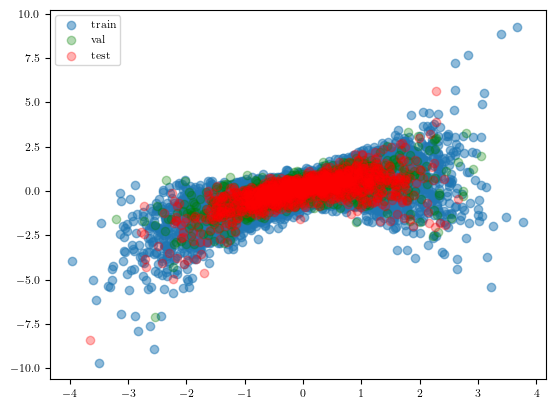

In [60]:
plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [61]:
L.seed_everything(0)

lr = 1e-3
gamma = 1e-3
epochs = int(1e5)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': [64,64],
    'dropout': 0,
    'iterative_whitening': False,
    'activation': GELU
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    NCP_model,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

early_stop = EarlyStopping(monitor="val_loss", patience=200, mode="min")
ckpt_path = "checkpoints/NCP"
if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path)
checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min", dirpath=ckpt_path)

logger_path = "lightning_logs/NCP"
if not os.path.exists(logger_path):
    os.makedirs(logger_path)


trainer = L.Trainer(**{
    'accelerator': 'auto',
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': True,
    'num_sanity_val_steps': 0,
    'check_val_every_n_epoch': 10,
    'enable_model_summary': True,
}, callbacks=[LitProgressBar(), early_stop, checkpoint_callback])

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [62]:
start = perf_counter()
trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
print(f'Training time: {perf_counter()-start}')

/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /media/gturri/deploy/NCP/NCP/examples/checkpoints/NCP exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 21.5 K
--------------------------------------
21.5 K    Trainable params
0         Non-trainable params
21.5 K    Total params
0.086     Total estimated model params size (MB)


0it [00:00, ?it/s]

Training time: 69.74241224299476


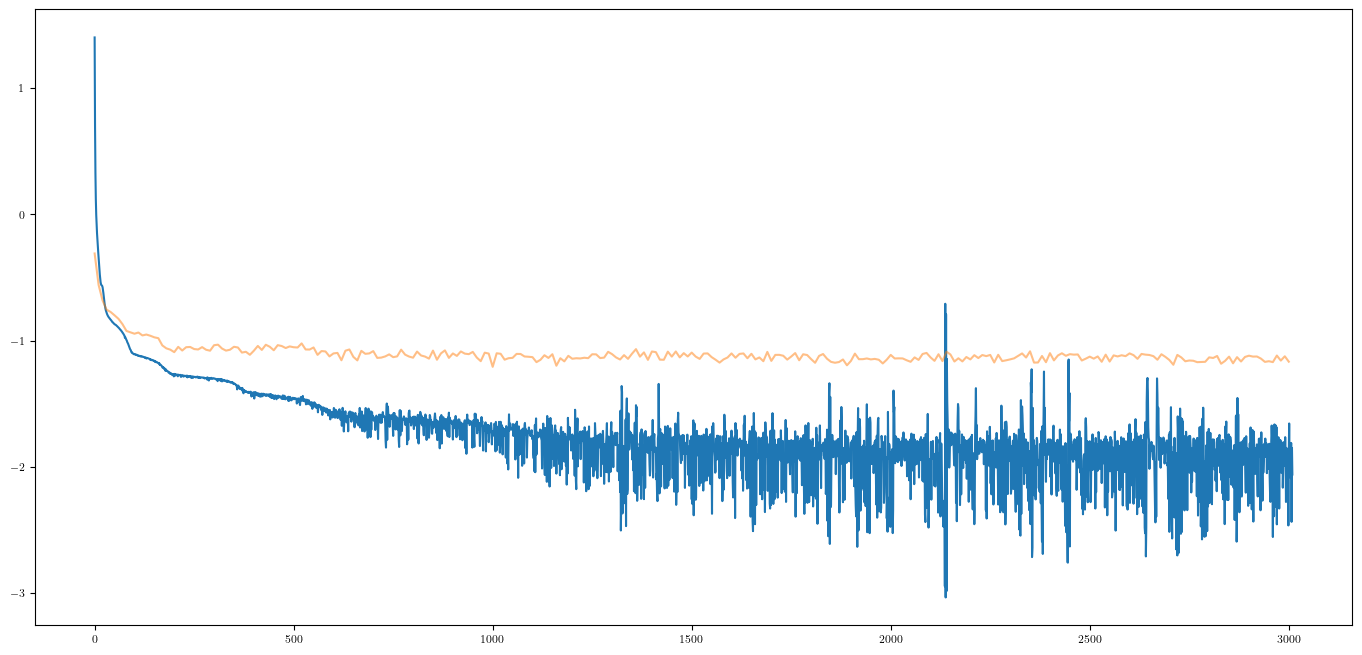

In [63]:
plt.figure(figsize=(17, 8))
plt.plot(np.arange(0, NCP_module.current_epoch, 1), np.array(NCP_module.train_loss))
plt.plot(np.arange(0, NCP_module.current_epoch, 10), np.array(NCP_module.val_loss), alpha=.5)
# plt.yscale('log')
plt.show()

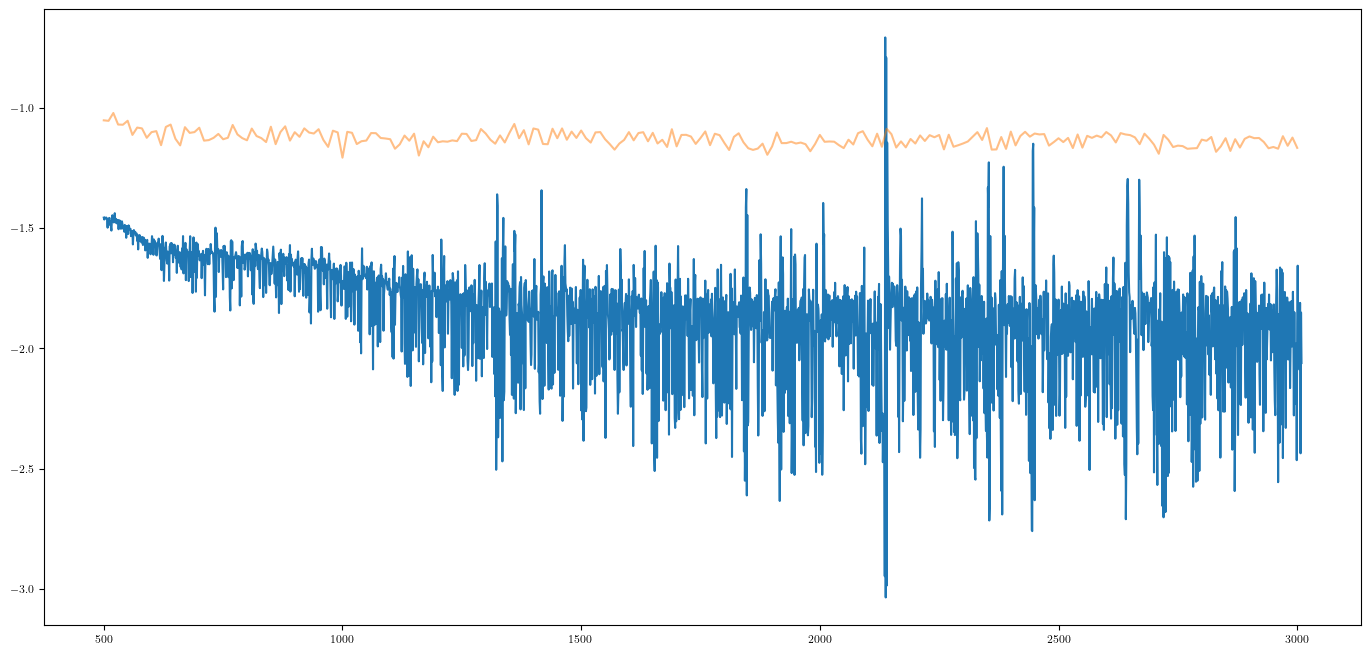

In [64]:
plt.figure(figsize=(17, 8))
plt.plot(np.arange(0, NCP_module.current_epoch, 1)[500:], np.array(NCP_module.train_loss)[500:])
plt.plot(np.arange(0, NCP_module.current_epoch, 10)[int(500/10):], np.array(NCP_module.val_loss)[int(500/10):], alpha=.5)
# plt.yscale('log')
plt.show()

In [65]:
best_model = torch.load(ckpt_path + '/best_model.pt').to('cpu')
print(checkpoint_callback.best_model_path)

/media/gturri/deploy/NCP/NCP/examples/checkpoints/NCP/epoch=1009-step=1010-v1.ckpt


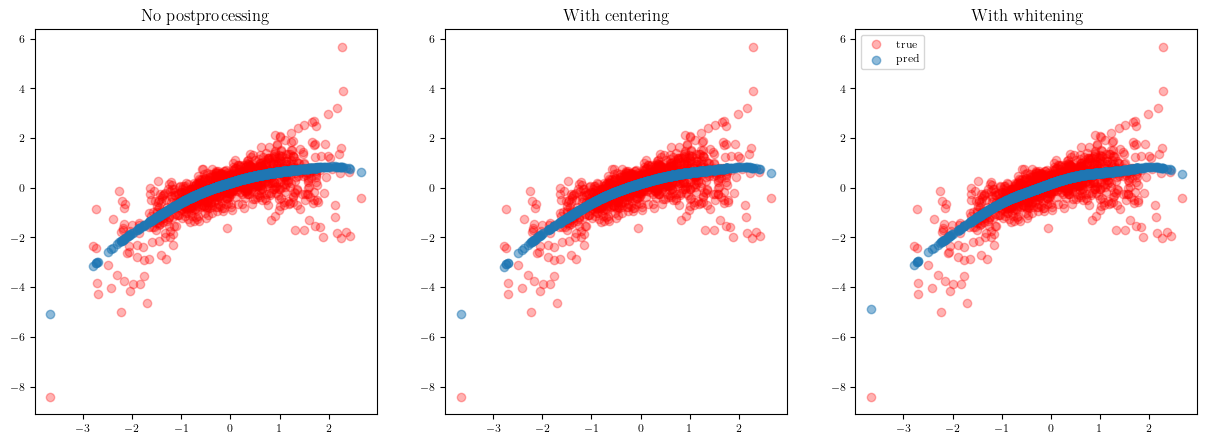

In [66]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

ax=axs[0]
pred = best_model.conditional_expectation(frnp(X_test), frnp(Y_train)).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = best_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = best_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

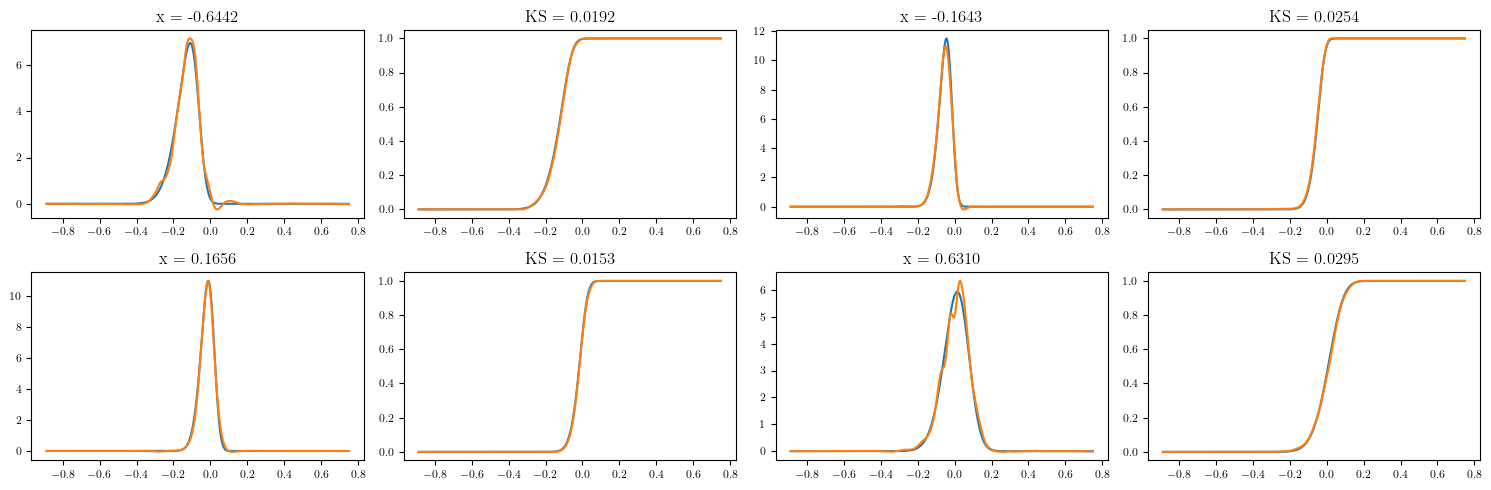

In [67]:
from NCP.cdf import compute_marginal, integrate_pdf
from NCP.metrics import *

x_grid = np.percentile(X_train, np.linspace(10, 90, num=4))
ys, step = np.linspace(Y_train.min(), Y_train.max(), num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))
p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
axes = ax.flatten()
postprocess = 'whitening'
for i, xi in enumerate(x_grid):
    xi = xi.reshape(1, -1)
    fys, pred_pdf = best_model.pdf(frnp([[xi]]), frnp(ys), postprocess=postprocess, p_y=p_y)
    fys = fys.reshape(-1, 1)
    true_pdf = density.pdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                           yscaler.inverse_transform(ys)).squeeze()
    axes[i*2].plot(yscaler.inverse_transform(fys), true_pdf)
    axes[i*2].plot(yscaler.inverse_transform(fys), pred_pdf.squeeze()/yscaler.scale_)

    pred_cdf = integrate_pdf(pred_pdf, ys)
    true_cdf = density.cdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                           yscaler.inverse_transform(ys)).squeeze()
    axes[i*2+1].plot(yscaler.inverse_transform(fys), true_cdf)
    axes[i*2+1].plot(yscaler.inverse_transform(fys), smooth_cdf(fys, pred_cdf))

    axes[i*2].set_title(r'x = {0:.4f}'.format(xscaler.inverse_transform(xi).squeeze()))
    axes[i*2+1].set_title(r'KS = {0:.4f}'.format(kolmogorov_smirnov(true_cdf, pred_cdf, fys)))

plt.tight_layout()
plt.show()

In [69]:
x_grid = np.percentile(X_train, np.linspace(5, 95, num=19))
ys, step = np.linspace(Y_train.min(), Y_train.max(), num=1000, retstep=True)
ys = ys.reshape(-1, 1)

postprocess = 'whitening'
scores = []
for xi in x_grid:
    fys, pred_pdf = best_model.pdf(frnp([[xi]]), frnp(ys), postprocess=postprocess, p_y=p_y)
    # pred_cdf = pdf2cdf(pred_pdf, step)
    pred_cdf = integrate_pdf(pred_pdf, ys)
    true_cdf = density.cdf(np.tile(xscaler.inverse_transform([[xi]]), (len(ys),1)),
                                           yscaler.inverse_transform(ys)).squeeze()

    result = compute_metrics(true_cdf, pred_cdf, metrics='all', smooth=True, values=fys)
    result['x'] = xi

    scores.append(result)
scores = pd.DataFrame(scores)

In [70]:
scores.kolmogorov_smirnov.mean()

0.019122055

In [71]:
np.sort(np.exp(-best_model.state_dict()['S.weights']**2))

array([0.99623716, 0.9994612 , 0.99967664, 0.9997445 , 0.9997566 ,
       0.9997628 , 0.99980277, 0.99985623, 0.9998967 , 0.99990004,
       0.99990773, 0.9999122 , 0.9999208 , 0.9999365 , 0.9999509 ,
       0.9999535 , 0.99995613, 0.99997437, 0.999987  , 0.99998707,
       0.9999884 , 0.9999893 , 0.9999916 , 0.99999183, 0.99999607,
       0.99999636, 0.9999966 , 0.99999774, 0.9999979 , 0.9999987 ,
       0.9999997 , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [72]:
best_model.state_dict()['_sing_val']

tensor([0.7499, 0.6058, 0.5790, 0.4961, 0.3727, 0.3020, 0.2296, 0.1643, 0.1278,
        0.0859])

## Gaussian Mixture

In [16]:
Ntrain = int(1e5)
Nval = int(1e3)
Ntest = int(1e3)

ndim_x = 1
ndim_y = 1
# density = GaussianMixture(n_kernels = 2, ndim_x=ndim_x, ndim_y=ndim_y, means_std=5, random_seed=0)
density = GaussianMixture(ndim_x=ndim_x, ndim_y=ndim_y, means_std=3, random_seed=42)
X, Y = density.simulate(n_samples=int(1e5) + Nval)
if X.ndim == 1:
    X = X.reshape(-1, 1)
if Y.ndim == 1:
    Y = Y.reshape(-1, 1)
X_train, X_val, Y_train, Y_val = X[:Ntrain,:], X[-Nval:,:], Y[:Ntrain,:], Y[-Nval:,:]
xscaler = StandardScaler()
yscaler = StandardScaler()
X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

X_test, Y_test = density.simulate(n_samples=Ntest)
if X_test.ndim == 1:
    X_test = X_test.reshape(-1, 1)
if Y_test.ndim == 1:
    Y_test = Y_test.reshape(-1, 1)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)

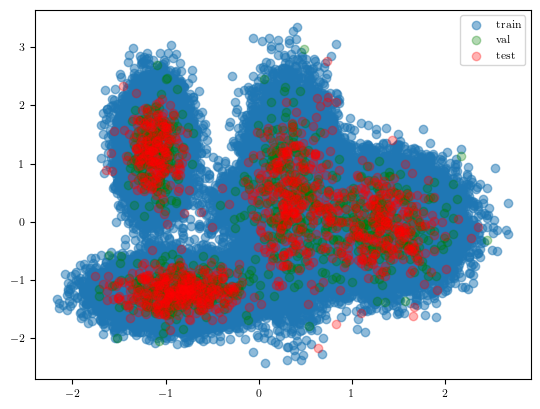

In [18]:

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [19]:
L.seed_everything(0)

lr = 1e-3
gamma = 1e-3
epochs = int(1e5)

U_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': [64,64],
    'dropout': 0,
    'iterative_whitening': False,
    'activation': GELU
}

V_kwargs = {
    'input_shape': Y_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': [64,64],
    'dropout': 0,
    'iterative_whitening': False,
    'activation': GELU
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=U_kwargs, V_operator_kwargs=V_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    NCP_model,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

early_stop = EarlyStopping(monitor="val_loss", patience=200, mode="min")
ckpt_path = "checkpoints/NCP"
if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path)
checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min", dirpath=ckpt_path)

logger_path = "lightning_logs/NCP"
if not os.path.exists(logger_path):
    os.makedirs(logger_path)


trainer = L.Trainer(**{
    'accelerator': 'auto',
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': True,
    'num_sanity_val_steps': 0,
    'check_val_every_n_epoch': 10,
    'enable_model_summary': True,
}, callbacks=[LitProgressBar(), early_stop, checkpoint_callback])

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [20]:
start = perf_counter()
trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
fit_time = perf_counter() - start

/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /media/gturri/deploy/NCP/NCP/examples/checkpoints/NCP exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 21.5 K
--------------------------------------
21.5 K    Trainable params
0         Non-trainable params
21.5 K    Total params
0.086     Total estimated model params size (MB)


0it [00:00, ?it/s]

In [21]:
print('N epochs: {0}'.format(NCP_module.current_epoch - early_stop.patience*trainer.check_val_every_n_epoch))
print('Training loss: {0}'.format(NCP_module.train_loss[-early_stop.patience*trainer.check_val_every_n_epoch]))
print('Validation loss: {0}'.format(NCP_module.val_loss[-early_stop.patience]))
print('Fit time: {0}'.format(fit_time))

N epochs: 2260
Training loss: -2.1680405139923096
Validation loss: -2.1953494548797607
Fit time: 433.29248050102615


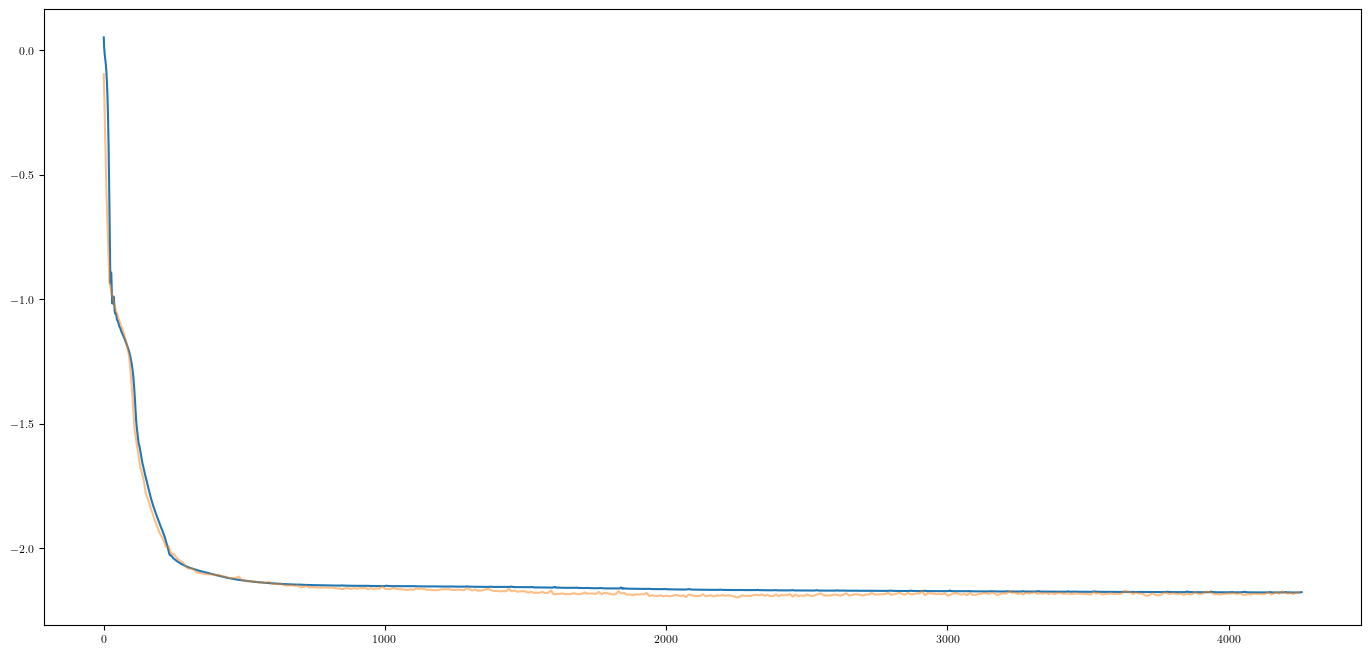

In [22]:
plt.figure(figsize=(17, 8))
plt.plot(np.arange(0, NCP_module.current_epoch, 1), np.array(NCP_module.train_loss))
plt.plot(np.arange(0, NCP_module.current_epoch, 10), np.array(NCP_module.val_loss), alpha=.5)
# plt.yscale('log')
plt.show()

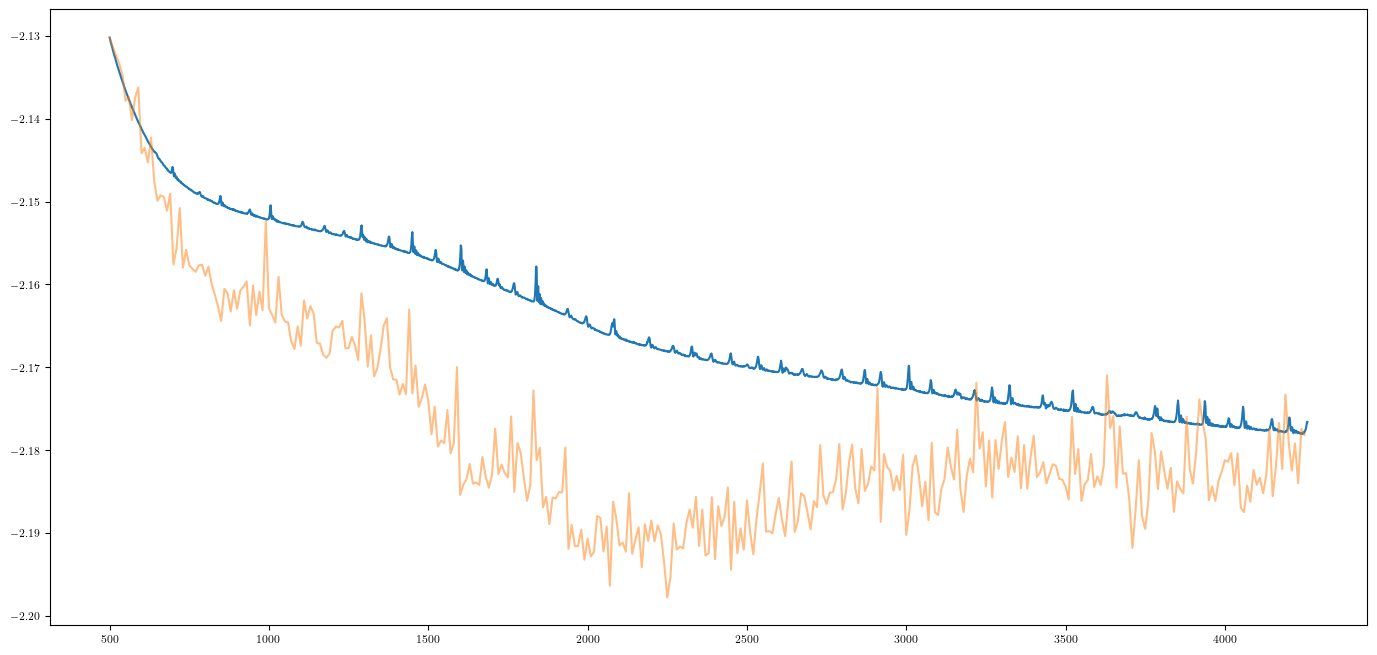

In [23]:
plt.figure(figsize=(17, 8))
plt.plot(np.arange(0, NCP_module.current_epoch, 1)[500:], np.array(NCP_module.train_loss)[500:])
plt.plot(np.arange(0, NCP_module.current_epoch, 10)[int(500/10):], np.array(NCP_module.val_loss)[int(500/10):], alpha=.5)
# plt.yscale('log')
plt.show()

In [24]:
best_model = torch.load(ckpt_path + '/best_model.pt').to('cpu')
print(checkpoint_callback.best_model_path)

/media/gturri/deploy/NCP/NCP/examples/checkpoints/NCP/epoch=2259-step=2260.ckpt


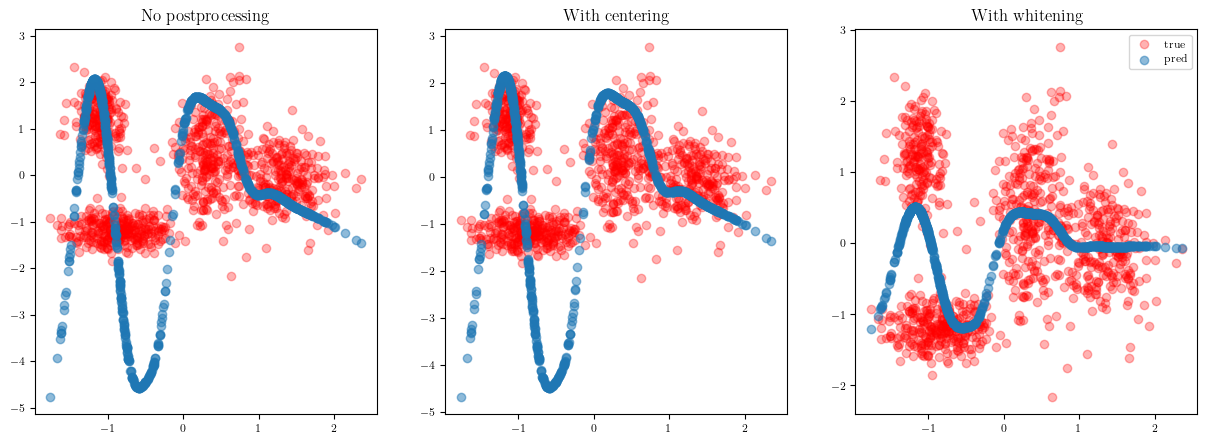

In [25]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
ax=axs[0]
pred = best_model.conditional_expectation(frnp(X_test), frnp(Y_train)).reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = best_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='centering').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = best_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test, Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test, pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

/media/gturri/deploy/NCP/NCP/utils.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.Tensor(x).to(device)


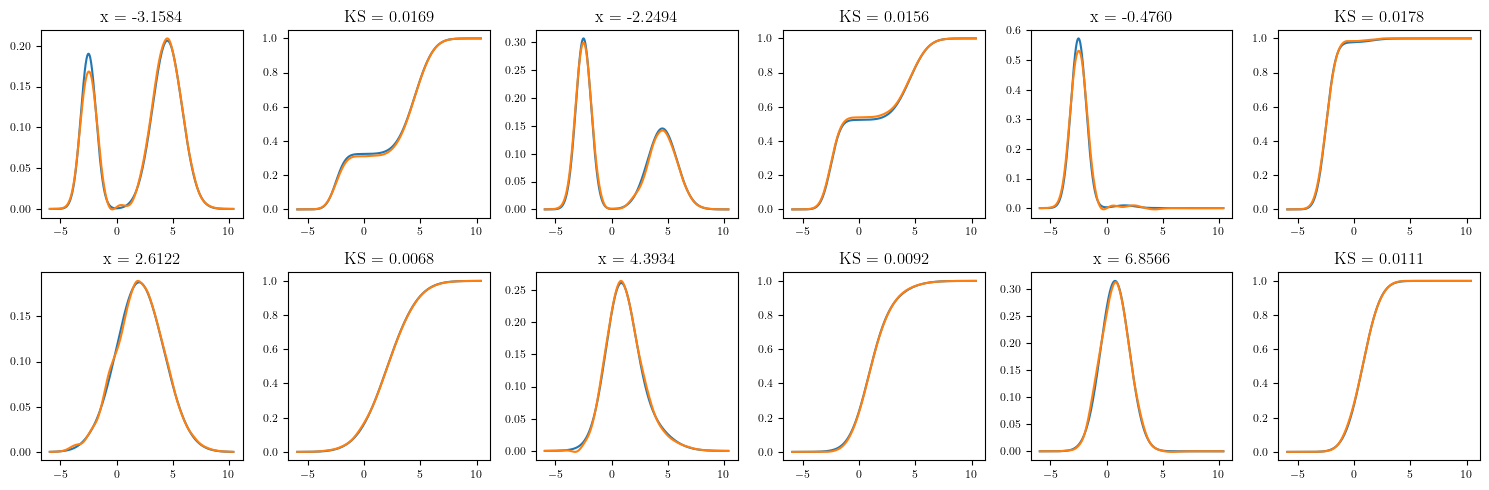

In [26]:
from NCP.cdf import compute_marginal, integrate_pdf
from NCP.metrics import *

x_grid = np.percentile(X_train, np.linspace(10, 90, num=6))
ys, step = np.linspace(Y_train.min(), Y_train.max(), num=1000, retstep=True)
ys = frnp(ys.reshape(-1, 1))
p_y = compute_marginal(bandwidth='scott').fit(Y_train)

fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(15,5))
axes = ax.flatten()
postprocess = 'whitening'
for i, xi in enumerate(x_grid):
    xi = xi.reshape(1, -1)
    fys, pred_pdf = best_model.pdf(frnp([[xi]]), frnp(ys), postprocess=postprocess, p_y=p_y)
    fys = fys.reshape(-1, 1)
    true_pdf = density.pdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                           yscaler.inverse_transform(ys)).squeeze()
    axes[i*2].plot(yscaler.inverse_transform(fys), true_pdf)
    axes[i*2].plot(yscaler.inverse_transform(fys), pred_pdf.squeeze()/yscaler.scale_)

    pred_cdf = integrate_pdf(pred_pdf, ys)
    true_cdf = density.cdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
                                           yscaler.inverse_transform(ys)).squeeze()
    axes[i*2+1].plot(yscaler.inverse_transform(fys), true_cdf)
    axes[i*2+1].plot(yscaler.inverse_transform(fys), smooth_cdf(fys, pred_cdf))

    axes[i*2].set_title(r'x = {0:.4f}'.format(xscaler.inverse_transform(xi).squeeze()))
    axes[i*2+1].set_title(r'KS = {0:.4f}'.format(kolmogorov_smirnov(true_cdf, pred_cdf, fys)))

plt.tight_layout()
plt.show()

In [27]:
x_grid = np.percentile(X_train, np.linspace(5, 95, num=19))
ys, step = np.linspace(Y_train.min(), Y_train.max(), num=1000, retstep=True)
ys = ys.reshape(-1, 1)

postprocess = 'whitening'
scores = []
for xi in x_grid:
    fys, pred_pdf = best_model.pdf(frnp([[xi]]), frnp(ys), postprocess=postprocess, p_y=p_y)
    pred_cdf = integrate_pdf(pred_pdf, ys)
    true_cdf = density.cdf(np.tile(xscaler.inverse_transform([[xi]]), (len(ys),1)),
                                           yscaler.inverse_transform(ys)).squeeze()

    result = compute_metrics(true_cdf, pred_cdf, metrics='all', smooth=True, values=fys)
    result['x'] = xi

    scores.append(result)
scores = pd.DataFrame(scores)

In [28]:
print(scores.kolmogorov_smirnov.mean())

0.012699259


## Bimodal

In [5]:
from NCP.examples.tools.data_gen import LGGMD

In [6]:
Ntrain = int(1e4)
Nval = int(1e3)
Ntest = int(1e3)

ndim_x = 20
ndim_y = 1
density = LGGMD(random_seed=42)
X, Y = density.simulate(n_samples=int(1e5) + Nval)
if X.ndim == 1:
    X = X.reshape(-1, 1)
    Y = Y.reshape(-1, 1)
X_train, X_val, Y_train, Y_val = X[:Ntrain,:], X[-Nval:,:], Y[:Ntrain,:], Y[-Nval:,:]
xscaler = StandardScaler()
yscaler = StandardScaler()
X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)
X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)

X_test, Y_test = density.simulate(n_samples=Ntest)
if X_test.ndim == 1:
    X_test = X_test.reshape(-1, 1)
    Y_test = Y_test.reshape(-1, 1)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)

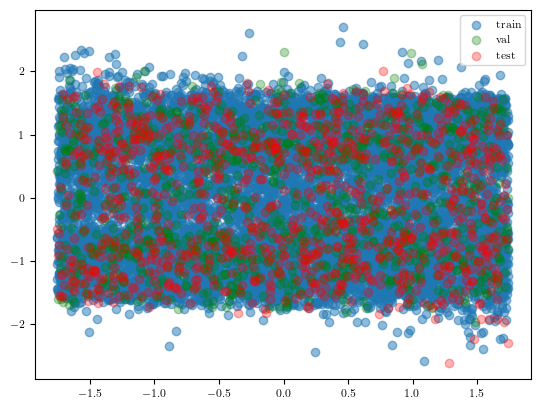

In [7]:
x_coord = 2
plt.scatter(X_train[:,x_coord], Y_train, alpha=0.5)
plt.scatter(X_val[:,x_coord], Y_val, color='green', alpha=0.3)
plt.scatter(X_test[:,x_coord], Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

In [8]:
L.seed_everything(0)

lr = 1e-3
gamma = 1e-3
epochs = int(1e5)

U_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': [64,64],
    'dropout': 0,
    'iterative_whitening': False,
    'activation': GELU
}

V_kwargs = {
    'input_shape': Y_train.shape[-1],
    'output_shape': 100,
    'n_hidden': 2,
    'layer_size': [64,64],
    'dropout': 0,
    'iterative_whitening': False,
    'activation': GELU
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

NCP_model = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=U_kwargs, V_operator_kwargs=V_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    NCP_model,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

early_stop = EarlyStopping(monitor="val_loss", patience=200, mode="min")
ckpt_path = "checkpoints/NCP"
if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path)
checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min", dirpath=ckpt_path)

logger_path = "lightning_logs/NCP"
if not os.path.exists(logger_path):
    os.makedirs(logger_path)


trainer = L.Trainer(**{
    'accelerator': 'auto',
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': True,
    'num_sanity_val_steps': 0,
    'check_val_every_n_epoch': 10,
    'enable_model_summary': True,
}, callbacks=[LitProgressBar(), early_stop, checkpoint_callback])

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
start = perf_counter()
trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
print(f'Training time: {perf_counter()-start}')

/home/gturri/miniconda3/envs/NCP/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /media/gturri/deploy/NCP/NCP/examples/checkpoints/NCP exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 22.7 K
--------------------------------------
22.7 K    Trainable params
0         Non-trainable params
22.7 K    Total params
0.091     Total estimated model params size (MB)


0it [00:00, ?it/s]

Training time: 32.04925748202368


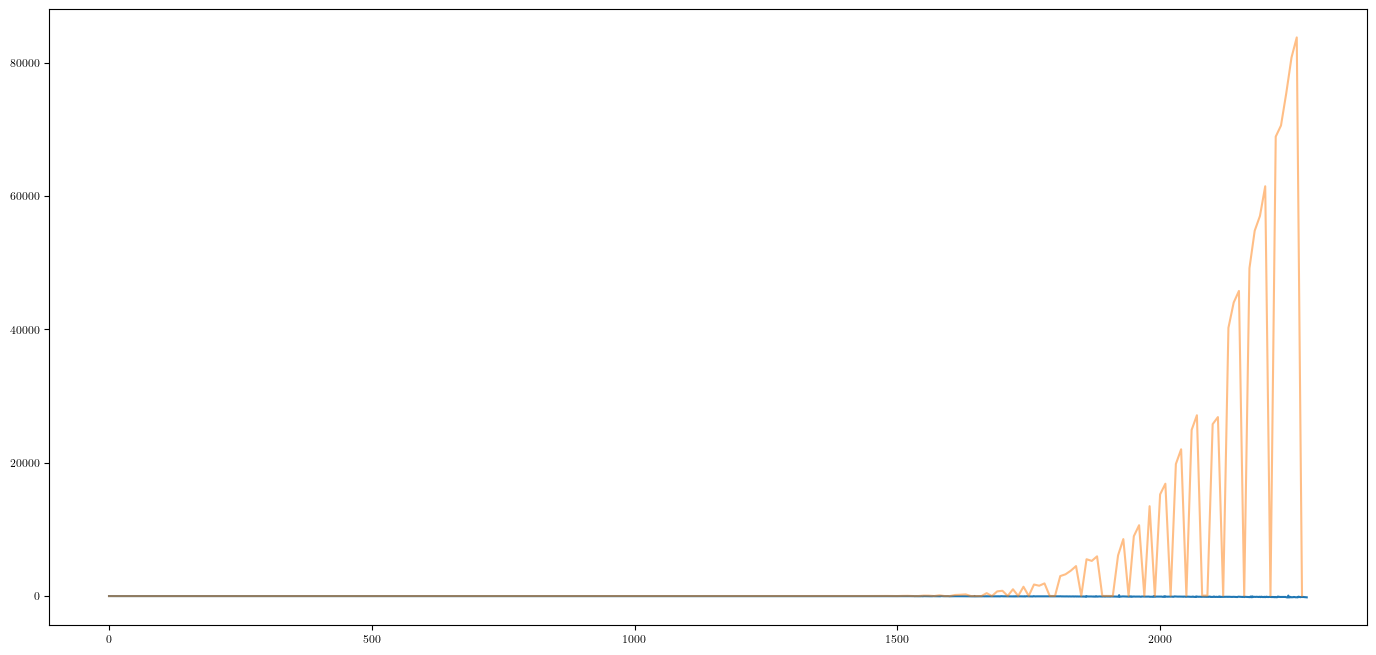

In [10]:
plt.figure(figsize=(17, 8))
plt.plot(np.arange(0, NCP_module.current_epoch, 1), np.array(NCP_module.train_loss))
plt.plot(np.arange(0, NCP_module.current_epoch, 10), np.array(NCP_module.val_loss), alpha=.5)
# plt.yscale('log')
plt.show()

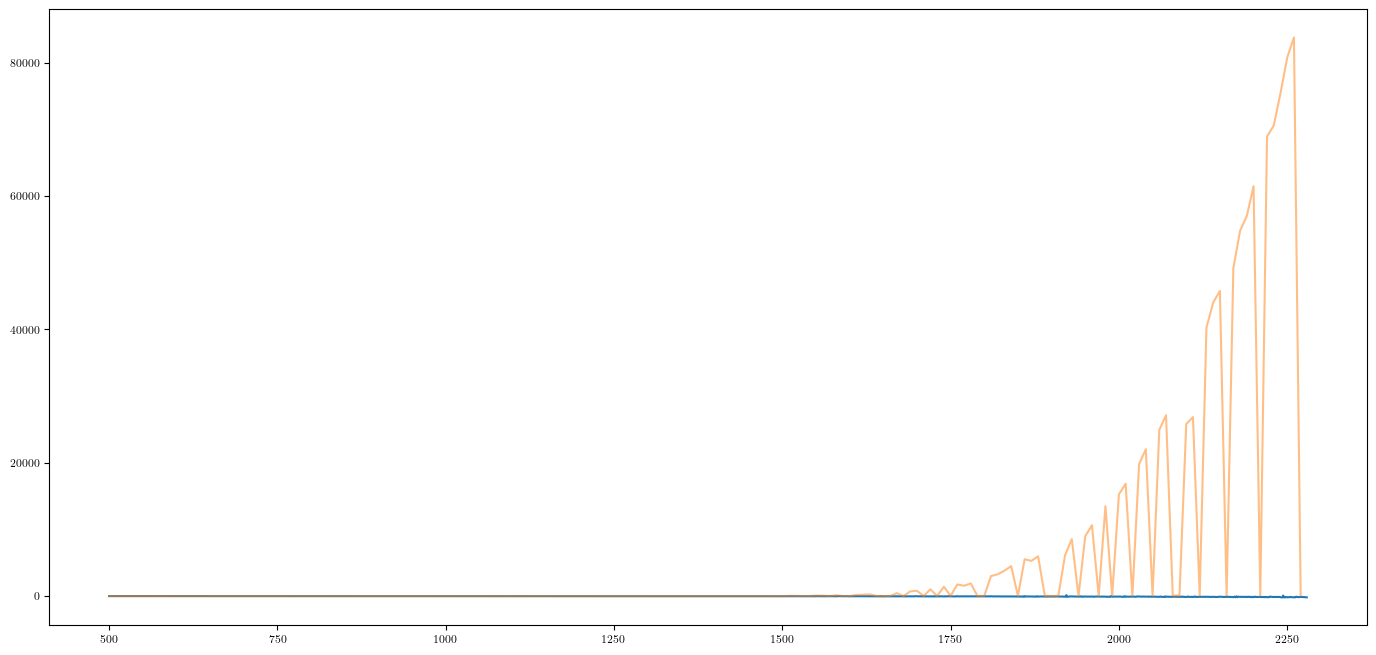

In [11]:
plt.figure(figsize=(17, 8))
plt.plot(np.arange(0, NCP_module.current_epoch, 1)[500:], np.array(NCP_module.train_loss)[500:])
plt.plot(np.arange(0, NCP_module.current_epoch, 10)[int(500/10):], np.array(NCP_module.val_loss)[int(500/10):], alpha=.5)
# plt.yscale('log')
plt.show()

In [12]:
best_model = torch.load(ckpt_path + '/best_model.pt').to('cpu')
print(checkpoint_callback.best_model_path)

/media/gturri/deploy/NCP/NCP/examples/checkpoints/NCP/epoch=279-step=280.ckpt


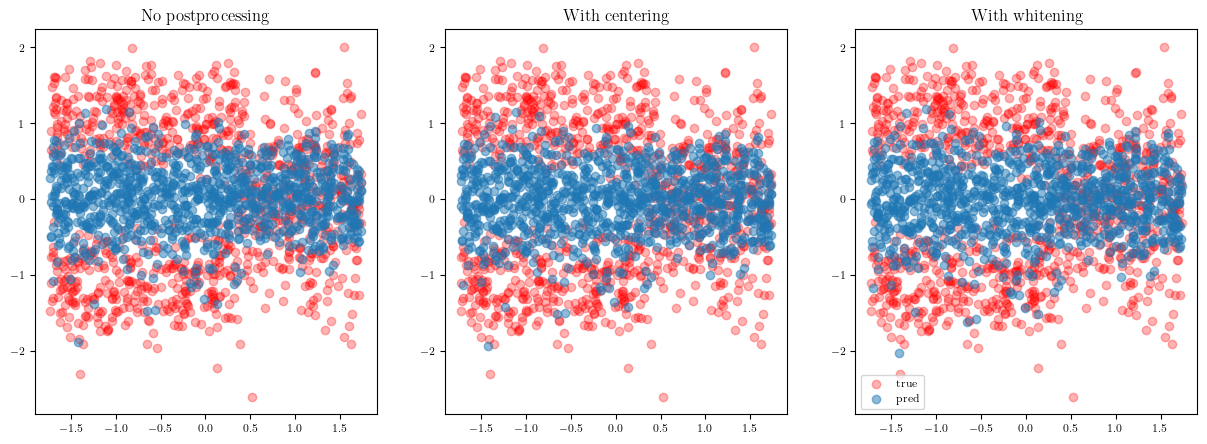

In [13]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
x_coord = 1
ax=axs[0]
pred = best_model.conditional_expectation(frnp(X_test), frnp(Y_train)).reshape(-1, 1)
ax.scatter(X_test[:,x_coord], Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test[:,x_coord], pred, alpha=0.5, label = 'pred')
ax.set_title('No postprocessing')

ax=axs[1]
pred = best_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='centering').reshape(-1, 1)
ax.scatter(X_test[:,x_coord], Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test[:,x_coord], pred, alpha=0.5, label = 'pred')
ax.set_title('With centering')

ax=axs[2]
pred = best_model.conditional_expectation(frnp(X_test), frnp(Y_train), postprocess='whitening').reshape(-1, 1)
ax.scatter(X_test[:,x_coord], Y_test, color='r', alpha=0.3, label='true')
ax.scatter(X_test[:,x_coord], pred, alpha=0.5, label = 'pred')
ax.set_title('With whitening')

plt.legend()
plt.show()

In [14]:
import itertools
from NCP.cdf import compute_marginal, integrate_pdf

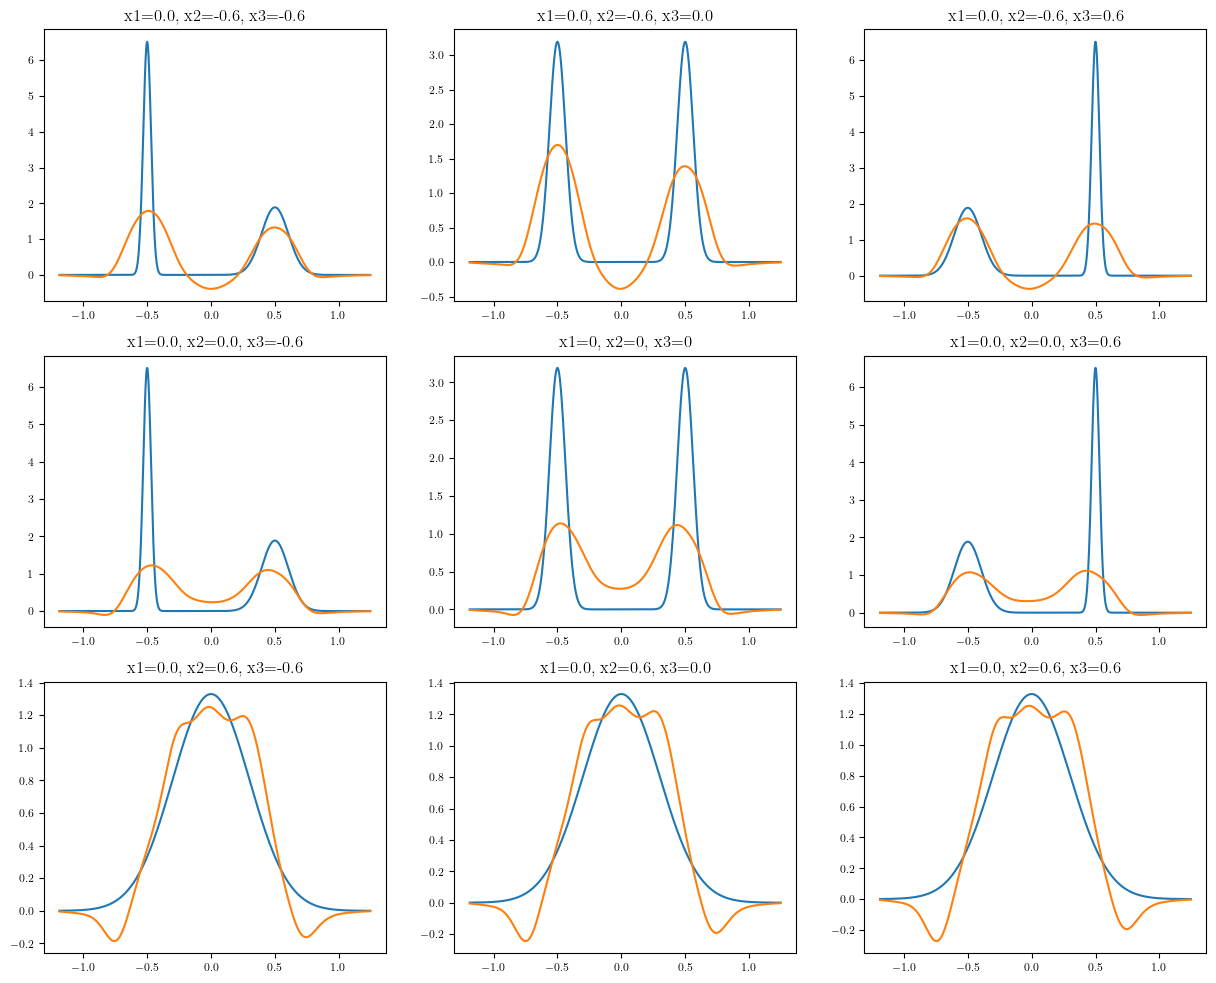

In [21]:
x1 = [0] # mean
x3 = [-0.6, 0, 0.6] # asymetry
x2 = [-0.6, 0, 0.6] # modality

x_grid = itertools.product(x1, x2, x3)

p1, p99 = np.percentile(Y_train, [1, 99])
ys, step = np.linspace(Y_train.min(), Y_train.max(), num=1000, retstep=True)
ys = ys.reshape(-1, 1)

fig, ax = plt.subplots(nrows=(len(x1)*len(x2)), ncols=len(x3), figsize=(15,12))
axes = ax.flatten()

postprocess = 'centering'
p_y = compute_marginal(bandwidth='scott').fit(Y_train)
for i, xi in enumerate(x_grid):
    xi = list(xi) + [0]*17          # fill all other dimensions by 0
    xi = np.array(xi)
    xi_scaled = xscaler.transform(xi.reshape(1, -1))
    fys, pred_pdf = best_model.pdf(frnp(xi_scaled), frnp(ys), postprocess=postprocess, p_y=p_y)
    fys = yscaler.inverse_transform(ys.reshape([-1, 1])).flatten()
    true_pdf = density.pdf(xi, fys)
    axes[i].plot(fys, true_pdf)
    axes[i].plot(fys, pred_pdf/yscaler.scale_)

    # pred_cdf = integrate_pdf(pred_pdf, yscaler.inverse_transform(ys))
    # true_cdf = density.cdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
    #                                        yscaler.inverse_transform(ys)).squeeze()
    # axes[i].plot(yscaler.inverse_transform(fys), true_cdf)
    # axes[i].plot(yscaler.inverse_transform(fys), smooth_cdf(fys, pred_cdf))

    # axes[i].set_title(r'x = {0}'.format(xi[:,i//4]))
    # axes[i].set_title(r'KS = {0:.4f}'.format(kolmogorov_smirnov(true_cdf, pred_cdf, fys)))

    axes[i].set_title(f'x1={np.round(xi[0], 3)}, x2={np.round(xi[1], 3)}, x3={np.round(xi[2], 3)}')

# plt.savefig('figures/smooth_cdf_2.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [26]:
from NCP.metrics import kolmogorov_smirnov, smooth_cdf, compute_metrics

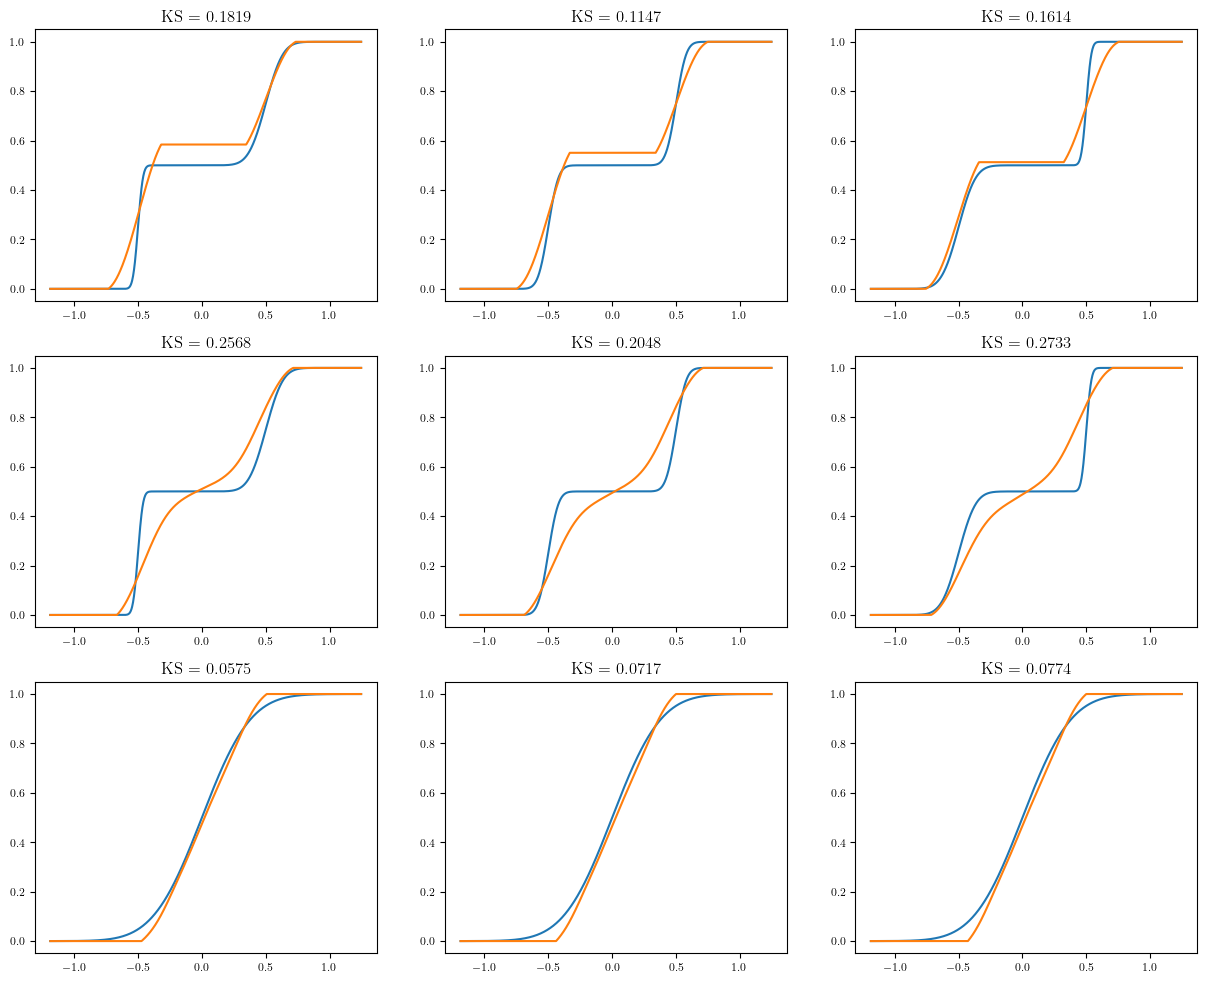

In [24]:
x1 = [0] # mean
x3 = [-0.6, 0, 0.6] # asymetry
x2 = [-0.6, 0, 0.6] # modality

x_grid = itertools.product(x1, x2, x3)

p1, p99 = np.percentile(Y_train, [1, 99])
ys, step = np.linspace(Y_train.min(), Y_train.max(), num=1000, retstep=True)
ys = ys.reshape(-1, 1)

fig, ax = plt.subplots(nrows=(len(x1)*len(x2)), ncols=len(x3), figsize=(15,12))
axes = ax.flatten()

postprocess = 'centering'
p_y = compute_marginal(bandwidth='scott').fit(Y_train)
for i, xi in enumerate(x_grid):
    xi = list(xi) + [0]*17          # fill all other dimensions by 0
    xi = np.array(xi)
    xi_scaled = xscaler.transform(xi.reshape(1, -1))
    fys, pred_pdf = best_model.pdf(frnp(xi_scaled), frnp(ys), postprocess=postprocess, p_y=p_y)
    fys = yscaler.inverse_transform(ys.reshape([-1, 1])).flatten()
    pred_cdf = integrate_pdf(pred_pdf, fys)
    true_cdf = density.cdf(xi, fys)
    axes[i].plot(fys, true_cdf)
    axes[i].plot(fys, smooth_cdf(fys, pred_cdf))

    # pred_cdf = integrate_pdf(pred_pdf, yscaler.inverse_transform(ys))
    # true_cdf = density.cdf(np.tile(xscaler.inverse_transform(xi), (len(ys),1)),
    #                                        yscaler.inverse_transform(ys)).squeeze()
    # axes[i].plot(yscaler.inverse_transform(fys), true_cdf)
    # axes[i].plot(yscaler.inverse_transform(fys), smooth_cdf(fys, pred_cdf))

    # axes[i].set_title(r'x = {0}'.format(xi[:,i//4]))
    axes[i].set_title(r'KS = {0:.4f}'.format(kolmogorov_smirnov(true_cdf, pred_cdf, fys)))
    #
    # axes[i].set_title(f'x1={round(xi[0], 3)}, x2={round(xi[1], 3)}, x3={round(xi[2], 3)}')

# plt.savefig('figures/smooth_cdf_2.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [28]:
n_sampling = 19
ndim_x = 20
x_grid = np.zeros((n_sampling*3, ndim_x)) # 3 is the number of features on which I want to condition on

for i in range(ndim_x):
    x_grid[:, i] = np.repeat(np.percentile(X_train[:, i], 50), x_grid.shape[0], axis=0)

for i in range(3):
    x_grid[i * n_sampling:(i + 1) * n_sampling, i] = np.percentile(X_train[:, i], np.linspace(5, 95, num=n_sampling))

ys, step = np.linspace(Y_train.min(), Y_train.max(), num=1000, retstep=True)
ys = ys.reshape(-1, 1)

postprocess = 'centering'
scores = []
for xi in x_grid:
    xi = xi.reshape(1, -1)
    fys, pred_pdf = best_model.pdf(frnp(xi), frnp(ys), postprocess=postprocess, p_y=p_y)
    # pred_cdf = pdf2cdf(pred_pdf, step)
    pred_cdf = integrate_pdf(pred_pdf, ys)
    true_cdf = density.cdf(xscaler.inverse_transform(xi), yscaler.inverse_transform(ys)).squeeze()

    result = compute_metrics(true_cdf, pred_cdf, metrics='all', smooth=True, values=fys)
    result['x'] = xi

    scores.append(result)
scores = pd.DataFrame(scores)

In [29]:
density.cdf(xscaler.inverse_transform(xi), yscaler.inverse_transform(ys)).squeeze()

array([3.37609928e-08, 3.73572292e-08, 4.13226647e-08, 4.56936894e-08,
       5.05101202e-08, 5.58155072e-08, 6.16574664e-08, 6.80880391e-08,
       7.51640826e-08, 8.29476918e-08, 9.15066567e-08, 1.00914957e-07,
       1.11253296e-07, 1.22609680e-07, 1.35080043e-07, 1.48768918e-07,
       1.63790171e-07, 1.80267782e-07, 1.98336695e-07, 2.18143731e-07,
       2.39848575e-07, 2.63624834e-07, 2.89661183e-07, 3.18162591e-07,
       3.49351650e-07, 3.83469991e-07, 4.20779818e-07, 4.61565551e-07,
       5.06135587e-07, 5.54824199e-07, 6.07993568e-07, 6.66035961e-07,
       7.29376071e-07, 7.98473518e-07, 8.73825535e-07, 9.55969841e-07,
       1.04548771e-06, 1.14300727e-06, 1.24920699e-06, 1.36481947e-06,
       1.49063544e-06, 1.62750805e-06, 1.77635741e-06, 1.93817551e-06,
       2.11403140e-06, 2.30507674e-06, 2.51255170e-06, 2.73779121e-06,
       2.98223173e-06, 3.24741827e-06, 3.53501205e-06, 3.84679845e-06,
       4.18469562e-06, 4.55076351e-06, 4.94721350e-06, 5.37641859e-06,
      

In [30]:
density.cdf(np.repeat(xscaler.inverse_transform(xi), len(ys), axis=0),
                                       yscaler.inverse_transform(ys)).squeeze()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [239]:
scores.kolmogorov_smirnov.mean()

0.21256687

In [240]:
density.__class__.__name__

'LGGMD'

In [1]:
import numpy as np
from scipy.stats import multivariate_normal

class MixtureOfGaussians:
    def __init__(self, n_X, n_Y, K, random_state=None):
        np.random.seed(random_state)
        self.n_X = n_X
        self.n_Y = n_Y
        self.K = K
        self.random_state = random_state
        
        # Initialize mixture coefficients
        self.pi = np.random.dirichlet(alpha=np.ones(K))
        
        # Initialize means and covariances for each component
        self.means = np.array([np.random.randn(n_X + n_Y) for _ in range(K)])
        self.covariances = np.array([self._random_covariance_matrix(n_X + n_Y) for _ in range(K)])
    
    def _random_covariance_matrix(self, dim):
        A = np.random.randn(dim, dim)
        return np.dot(A, A.T)
    
    def sample(self, n_samples):
        samples = np.zeros((n_samples, self.n_X + self.n_Y))
        component_assignments = np.random.choice(self.K, size=n_samples, p=self.pi)
        
        for k in range(self.K):
            n_k = np.sum(component_assignments == k)
            if n_k > 0:
                samples[component_assignments == k] = np.random.multivariate_normal(
                    mean=self.means[k], 
                    cov=self.covariances[k], 
                    size=n_k
                )
        
        X = samples[:, :self.n_X]
        Y = samples[:, self.n_Y:]
        return X, Y
    
    def pdf(self, X, Y):
        pdf_vals = np.zeros(X.shape[0])
        
        for k in range(self.K):
            mean_XY = self.means[k]
            cov_XY = self.covariances[k]
            pdf_vals += self.pi[k] * multivariate_normal.pdf(
                np.hstack([X, Y]), 
                mean=mean_XY, 
                cov=cov_XY
            )
        
        return pdf_vals
    
    def cdf(self, X, Y):
        cdf_vals = np.zeros(X.shape[0])
        
        for k in range(self.K):
            mean_XY = self.means[k]
            cov_XY = self.covariances[k]
            cdf_vals += self.pi[k] * multivariate_normal.cdf(
                np.hstack([X, Y]), 
                mean=mean_XY, 
                cov=cov_XY
            )
        
        return cdf_vals

# Example usage:
n_X = 5
n_Y = 1
K = 3
random_state = 42
model = MixtureOfGaussians(n_X, n_Y, K, random_state)

# Generate a synthetic dataset
X, Y = model.sample(1000)

# Calculate PDF and CDF for a specific value of X and Y
X_test = np.array([[0.5, -0.2]])
Y_test = np.array([[0.1]])
pdf_val = model.pdf(X_test, Y_test)
cdf_val = model.cdf(X_test, Y_test)

print(f"PDF: {pdf_val}")
print(f"CDF: {cdf_val}")

PDF: [0.00990088]
CDF: [0.22891592]


In [3]:
# Example usage:
n_X = 5
n_Y = 1
K = 3
random_state = 42
model = MixtureOfGaussians(n_X, n_Y, K, random_state)

# Generate a synthetic dataset
X, Y = model.sample(1000)

# Calculate PDF and CDF for a specific value of X and Y
X_test = np.array([[0.5, -0.2, 0, 0, 0]])
ys, step = np.linspace(Y.min(), Y.max(), num=1000, retstep=True)
ys = ys.reshape(-1, 1)
pdf_val = model.pdf(X_test, ys)
cdf_val = model.cdf(X_test, ys)

print(f"PDF: {pdf_val}")
print(f"CDF: {cdf_val}")

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1 and the array at index 1 has size 1000

In [5]:
Y.shape

(1000, 5)